In [12]:
import os
os.environ['OPENBLAS_NUM_THREADS'] = '1'

%matplotlib inline
from copy import deepcopy as copy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
from scipy import stats
import scipy.io as sio
import pandas as pd
import pickle
from collections import OrderedDict
from scipy.ndimage.interpolation import shift
from functools import reduce
import time
import re
from scipy.special import comb
import time
import asyncio
from bisect import bisect_left

from aux import Generic, bin_occurrences, safe_apply_stat, flatten
from disp import set_font_size, get_spaced_colors, graph_weight_matrix
from ntwk import LIFNtwkG
from utils.general import *
from utils.file_io import *

dt = 0.05e-3

In [13]:
def save_fig(fig, path, name):
    if not os.path.exists(path):
        os.makedirs(path)
    fig.savefig(os.path.join(path, name))

In [14]:

def get_equally_spaced_colors(n, cmap='autumn'):
    cmap = plt.get_cmap(cmap)
    colors = cmap(np.linspace(0, 1, n))
    return [matplotlib.colors.rgb2hex(rgba) for rgba in colors]

In [15]:
def process_single_activation(exc_raster, n):
    # extract first spikes
    first_spk_times = np.nan * np.ones(n)
    for i in range(exc_raster.shape[1]):
        nrn_idx = int(exc_raster[1, i])
        if np.isnan(first_spk_times[nrn_idx]):
            first_spk_times[nrn_idx] = exc_raster[0, i]
    return first_spk_times

In [16]:
def load_exp_data(direc, cut=None, layer_size=10, n_exc=1000, new_cell_idx=1000, name_frags=[], reverse=False):
    file_names = [f for f in sorted(all_files_from_dir(direc))]
    file_names = [f for f in filter_list_by_name_frags(file_names, name_frags)]
    if cut is not None:
        file_names = file_names[:cut]
        
    included_cell_mask = None
    file_name_count = range(0, len(file_names))
    if reverse:
        file_name_count = reversed(file_name_count)
    for i_f in file_name_count:
        file = file_names[i_f]
        
        if i_f == 0:
            loaded = sio.loadmat(os.path.join(direc, file))
        
        def lazy_load():
            loaded = sio.loadmat(os.path.join(direc, file))

            exc_raster = loaded['exc_raster']
            inh_raster = loaded['inh_raster']

            first_spk_times = process_single_activation(loaded['exc_raster'].astype(float), n_exc)

            layers_active = []
            layer_weights = []

            data = {
                'index': i_f,
                'first_spk_times': first_spk_times,
                
                'w_e_e': loaded['w_e_e'][0],
                'w_e_i': loaded['w_e_i'][0],
                'w_i_e': loaded['w_i_e'][0],
                
                'exc_raster': exc_raster,
                'inh_raster': inh_raster,
                'freqs': loaded['freqs'][0],
                'spk_bins': loaded['spk_bins'][0],
                
                'prop_speed': loaded['prop_speed'][0],
                'avg_temporal_width': loaded['avg_temporal_width'][0],
                'stable': loaded['stable'][0],
                
                'exc_raster_unperturbed': exc_raster,
            }
            if 'gs' in loaded:
                data['gs'] = loaded['gs']
                
            if 'w_r_e' in loaded:
                data['w_r_e'] = loaded['w_r_e']
                data['w_r_i'] = loaded['w_r_i']
                
            surviving_cell_mask = None
            if 'surviving_cell_mask' in loaded:
                surviving_cell_mask = loaded['surviving_cell_mask'][0, :].astype(bool)
                data['surviving_cell_mask'] = surviving_cell_mask
                
                sorting_order = np.argsort(exc_raster[1, :])
                exc_raster_sorted = exc_raster[:, sorting_order]
                indices = np.arange(len(surviving_cell_mask))[surviving_cell_mask.astype(bool)]
                
                exc_raster_unperturbed = []
                exc_raster_perturbed = []
                
                j = 0
                for idx in np.arange(exc_raster_sorted.shape[1]):
                    if j >= len(indices):
                        exc_raster_perturbed.append(exc_raster_sorted[:, idx].reshape(2, 1))
                    elif exc_raster_sorted[1, idx] < indices[j]:
                        exc_raster_perturbed.append(exc_raster_sorted[:, idx].reshape(2, 1))
                    elif exc_raster_sorted[1, idx] == indices[j]:
                        exc_raster_unperturbed.append(exc_raster_sorted[:, idx].reshape(2, 1))
                    elif exc_raster_sorted[1, idx] > indices[j]:
                        j += 1
                
                data['exc_raster_unperturbed'] = np.concatenate(exc_raster_unperturbed, axis=1)
                data['exc_raster_perturbed'] = np.concatenate(exc_raster_perturbed, axis=1)
                
            if 'w_r_e' in loaded:
                w_r_e = data['w_r_e']
                
                w_r_e_e = w_r_e[:n_exc, :n_exc]
                w_r_e_i = w_r_e[n_exc:, :n_exc]
                
                if surviving_cell_mask is not None:
                    w_r_e_e_surviving = w_r_e_e[(surviving_cell_mask & (np.arange(n_exc) < new_cell_idx)).astype(bool), :]
                    summed_incoming_weights_e_e = np.sum(w_r_e_e_surviving[:, surviving_cell_mask], axis=1)
                    summed_incoming_weights_e_i = np.sum(w_r_e_i[:, surviving_cell_mask], axis=1)
                else:
                    summed_incoming_weights_e_e = np.sum(w_r_e_e, axis=1)
                    summed_incoming_weights_e_i = np.sum(w_r_e_i, axis=1)
                    
#                 print(np.nonzero(summed_incoming_weights_e_e)[0])
#                 print(np.nonzero(summed_incoming_weights_e_i)[0])

                data['summed_incoming_weights_e_e'] = summed_incoming_weights_e_e
                
                data['mean_incoming_summed_weights_e_e'] = np.mean(summed_incoming_weights_e_e)
                data['std_incoming_summed_weights_e_e'] = np.std(summed_incoming_weights_e_e)
                data['mean_incoming_summed_weights_e_i'] = np.mean(summed_incoming_weights_e_i)
                data['std_incoming_summed_weights_e_i'] = np.std(summed_incoming_weights_e_i)
                
            return data
        yield i_f, lazy_load

In [17]:
def downsample_raster(raster, cell_idxs_to_show):
    j = 0
    if raster.size == 0:
        return np.array([])
    sorted_raster = np.array([y for y in sorted(raster.T, key=lambda x: x[1])]).T
    downsampled = []
    for i in range(sorted_raster.shape[1]):
        while j < len(cell_idxs_to_show) and sorted_raster[1, i] > cell_idxs_to_show[j]:
            j += 1
        if j == len(cell_idxs_to_show):
            break
        if sorted_raster[1, i] == cell_idxs_to_show[j]:
            downsampled.append(sorted_raster[:, i])
    if len(downsampled) > 0:
        return np.stack(downsampled).T
    else:
        return np.array([])

def make_figure_1_sparse(name, cell_range=(0, 900), new_cell_idx=None, per_shown=1., layer_size=10, timepoints=[5, 9, 20], sort_timepoint=300, verify_chain_timepoints=None, color='black', reverse=True):
    n_cells = cell_range[1] - cell_range[0]
    
    if type(name) is list:
        all_dirs = filter_list_by_name_frags(all_in_dir('./robustness'), name)
    else:
        all_dirs = filter_list_by_name_frags(all_in_dir('./robustness'), [name])
    
    colors = get_equally_spaced_colors(20, cmap='gist_ncar')
    
    def rendition_label(n):
        if n == 0:
            n = 1
            return f'{n}' + r'$^{st}$ rendition'
        else:
            return f'{n}' + r'$^{th}$ rendition'
        
  
    count = 0
    for d_idx, exp_dir_name in enumerate(sorted(all_dirs)):
        count += 1
        print(exp_dir_name)
        scale = 1.1
        
        if exp_dir_name not in recovered_exp_names:
            continue
        
        fig = plt.figure(constrained_layout=True, figsize=(5 * len(timepoints) * scale, 5 * scale))
        gs = gridspec.GridSpec(ncols=len(timepoints), nrows=3, figure=fig)
        axs = [(fig.add_subplot(gs[:1, i]), fig.add_subplot(gs[1:, i])) for i in range(len(timepoints))]
           
        timepoint_names = [rendition_label(t * 10) for t in timepoints]
        j = len(timepoints) - 1 if reverse else 0
        
        first_first_spk_in_range = None
        last_first_spk_in_range = None
        
        cell_idxs_to_show = None
        cell_idx_names = None
        sorted_order = None

        i = 0
        sort_timepoint_hit = False
        for i, load_data in load_exp_data(os.path.join('./robustness', exp_dir_name), n_exc=n_cells, new_cell_idx=new_cell_idx, name_frags=[], reverse=reverse):
            if i == sort_timepoint:
                sort_timepoint_hit = True
                
                data = load_data()
                first_spk_times = data['first_spk_times']
                first_spk_times[np.isnan(first_spk_times)] = first_spk_times.max() + np.arange(np.sum(np.isnan(first_spk_times)))
                firing_idxs = np.arange(len(first_spk_times))
                
                cell_idxs_to_show = firing_idxs[np.logical_and(firing_idxs >= cell_range[0], firing_idxs < cell_range[1])].astype(int)
                shown_first_spk_times = first_spk_times[np.logical_and(firing_idxs >= cell_range[0], firing_idxs < cell_range[1])]
                
#                 to_show_mask = []
#                 for i_k, k in enumerate(range(0, len(firing_idxs), layer_size)):  
#                     x = np.zeros(layer_size)
#                     if i_k % 4 != 0:
#                         x[:int(per_shown * layer_size)] = 1
#                     np.random.shuffle(x)
#                     x = x[:np.minimum(layer_size, len(firing_idxs) - k)]
#                     to_show_mask.append(x)
#                 to_show_mask = np.concatenate(to_show_mask).astype(bool)
                
#                 cell_idxs_to_show = cell_idxs_to_show[to_show_mask]
#                 shown_first_spk_times = shown_first_spk_times[to_show_mask]
                
                
                cell_idx_to_order_map = np.zeros(np.max(cell_idxs_to_show) + 1).astype(int)
                for idx in range(len(cell_idxs_to_show)):
                    cell_idx_to_order_map[cell_idxs_to_show[idx]] = idx
                
                sorted_order = np.nan * np.ones(len(shown_first_spk_times))
                for idx2, k in enumerate(np.argsort(shown_first_spk_times)):
                    sorted_order[k] = idx2
                sorted_order = sorted_order[cell_idx_to_order_map]
            
            if ((j >= 0 and reverse) or (j < len(timepoints) and not reverse)) and i == timepoints[j]:
                if not sort_timepoint_hit:
                    break
                
                data = load_data() if (i != sort_timepoint) else data
                exc_cells_newly_active = data['exc_raster_perturbed'] if 'exc_raster_perturbed' in data else np.array([])
                exc_cells_initially_active = data['exc_raster_unperturbed'][:, data['exc_raster_unperturbed'][1, :] < new_cell_idx]
                
                exc_cells_initially_active_downsampled = downsample_raster(exc_cells_initially_active, cell_idxs_to_show)
                exc_cells_newly_active_downsampled = downsample_raster(exc_cells_newly_active, cell_idxs_to_show)
                    
                inh_raster = data['inh_raster']
                first_spk_times = data['first_spk_times']
                
                if len(exc_cells_initially_active_downsampled) == 0:
                    continue

                axs[j][1].scatter(exc_cells_initially_active_downsampled[0, :] * 1000, sorted_order[exc_cells_initially_active_downsampled[1, :].astype(int)], s=10, c='black', zorder=0, alpha=1, marker='|')
                if exc_cells_newly_active_downsampled.size > 0:
                    axs[j][1].scatter(exc_cells_newly_active_downsampled[0, :] * 1000, sorted_order[exc_cells_newly_active_downsampled[1, :].astype(int)], s=10, c='#FF00FF', zorder=0, alpha=1, marker='|')
                    
                    
                if len(inh_raster) > 0:
                    axs[j][0].scatter(inh_raster[0, :] * 1000, inh_raster[1, :] - n_cells, s=10, c='blue', zorder=0, alpha=1, marker='|')
                axs[j][1].set_ylim(0, n_cells)
                axs[j][0].set_ylim(0, 30)
                axs[j][0].set_ylabel('Inhibitory\ncell Index')
                axs[j][1].set_ylabel('Excitatory\ncell Index')
                axs[j][1].set_xlabel('Time (ms)')
                axs[j][0].title.set_text(f'{timepoint_names[j]}')
            
                axs[j][0].spines['bottom'].set_visible(False)
                axs[j][1].spines['top'].set_visible(False)
                axs[j][0].tick_params(bottom=False, labelbottom=False)
                
                for row_idx in range(2):
                    # axs[j][row_idx].set_xlim((first_first_spk_in_range - 0.001) * 1000, (last_first_spk_in_range + 0.001) * 1000)
                    axs[j][row_idx].set_xlim(0.05 * 1000, 0.18 * 1000)
                    set_font_size(axs[j][row_idx], 16)
                    axs[j][row_idx].spines['right'].set_visible(False)
                    axs[j][row_idx].set_ylim(6)
                if reverse:
                    j -= 1
                else:
                    j += 1
        
        fig.tight_layout()  
#         save_fig(fig, './figures/paper/rasters', f'{exp_dir_name}.svg')

In [ ]:
make_figure_1_sparse(
    ['DROP_SEV_0.5', 'CONDITION_no_repl_PER_SILENT_0_2022'],
    cell_range=(0, 200),
    new_cell_idx=200,
    timepoints=np.concatenate([[99, 100], [250]]),
    sort_timepoint=260,
    per_shown=1.,
    color='#c41f3b',
    reverse=True
)

In [22]:
def make_total_activity_plot(names, timepoint_ranges, labels, file_name_ext='', ylim1=None, ylim2=None,
                       ylabel1=None, ylabel2=None, tick_right=True, legend=True):
    scale = 2.5
    
    all_dirs = []
    for name in names:
        if type(name) is not list:
            name = [name]
        print(name)
        all_dirs.append([dirs for dirs in filter_list_by_name_frags(all_in_dir('./robustness'), name)])
        
    for idx, exp_dir_names in enumerate(all_dirs):
        
        for j, exp_dir_name in enumerate(exp_dir_names):
#             if j >= 3: 
#                 continue
            print(exp_dir_name)
            fig, axs = plt.subplots(len(timepoint_ranges), 1, sharex=True, sharey=False, figsize=(2.5 * scale, 6 * scale))

            durations_for_timpoint_ranges = [[] for n in range(len(timepoint_ranges))]
            
            for i, data_load in load_exp_data(os.path.join('./robustness', exp_dir_name), n_exc=200, name_frags=[], new_cell_idx=200):
                    
                data = data_load()
                
                activity_start = np.min(data['exc_raster_unperturbed'][0, :])
                activity_end = np.max(data['exc_raster_unperturbed'][0, :])
                
                duration = activity_end - activity_start
                
                for l, timepoint_range in enumerate(timepoint_ranges):
                    if i >= timepoint_range[0] and i < timepoint_range[1]:
                        durations_for_timpoint_ranges[l].append(duration * 1000)
        
            for k, durations in enumerate(durations_for_timpoint_ranges):
                axs[k].hist(durations, bins=50, range=(0, 100), color='red')
                axs[k].set_xlim(0, 100)
                axs[k].set_ylim(0, 50)
                
                set_font_size(axs[k], 20)
                axs[k].spines['top'].set_visible(False)
                axs[k].spines['right'].set_visible(False)
                axs[k].spines['left'].set_visible(False)
                
                if k == 0:
                    axs[k].tick_params(axis='y', which='both',length=0)
                else:
                    axs[k].set_yticks([])
                
                
                axs[k].tick_params(axis='x', which='both',length=0)
                
                if k == 0:
                    axs[k].text(0.05, 0.9, f'Initial',
                                fontsize=20, verticalalignment='top', transform=axs[k].transAxes)
                if k == 1:
                    axs[k].text(0.05, 0.9, f'{labels[k]}% initial\nweight',
                                fontsize=20, verticalalignment='top', transform=axs[k].transAxes)
                elif k > 1:
                    axs[k].text(0.05, 0.9, f'{labels[k]}%',
                                fontsize=20, verticalalignment='top', transform=axs[k].transAxes)
                
            
            axs[0].set_ylabel('Counts')
            axs[-1].set_xlabel('Duration of activation (ms)')

    fig.tight_layout()
    save_fig(fig, './figures/paper/fig_2', f'mean_plot_{file_name_ext}.png')

['']
secreted__SEED_2032_W_E_E_0.0012_W_E_I_7e-05_W_I_E_5e-05_DROP_SEV_0.6_COMP_MECH_firing_rate_CONDITION_no_repl_no_syn_PER_SILENT_0_2022-07-11--16:20--13:9554
secreted__SEED_2026_W_E_E_0.0012_W_E_I_7e-05_W_I_E_5e-05_DROP_SEV_0.6_COMP_MECH_firing_rate_CONDITION_no_repl_no_syn_PER_SILENT_0_2022-07-11--16:20--13:2193
secreted__SEED_2009_W_E_E_0.0012_W_E_I_7e-05_W_I_E_5e-05_DROP_SEV_0.6_COMP_MECH_firing_rate_CONDITION_no_repl_no_syn_PER_SILENT_0_2022-07-11--13:08--41:0602
secreted__SEED_2024_W_E_E_0.0012_W_E_I_7e-05_W_I_E_5e-05_DROP_SEV_0.6_COMP_MECH_firing_rate_CONDITION_no_repl_no_syn_PER_SILENT_0_2022-07-11--16:20--10:5879
secreted__SEED_2004_W_E_E_0.0012_W_E_I_7e-05_W_I_E_5e-05_DROP_SEV_0.6_COMP_MECH_firing_rate_CONDITION_no_repl_no_syn_PER_SILENT_0_2022-07-11--13:08--40:5876
secreted__SEED_2012_W_E_E_0.0012_W_E_I_7e-05_W_I_E_5e-05_DROP_SEV_0.6_COMP_MECH_firing_rate_CONDITION_no_repl_no_syn_PER_SILENT_0_2022-07-11--13:08--52:0713
secreted__SEED_2007_W_E_E_0.0012_W_E_I_7e-05_W_I_E_5e

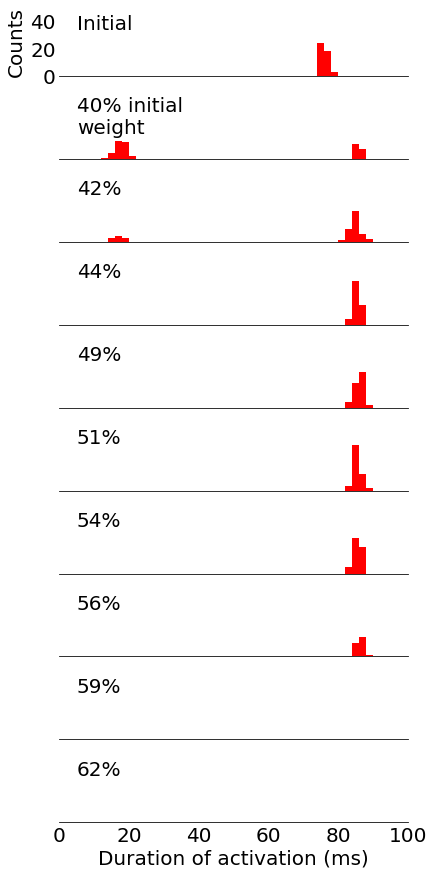

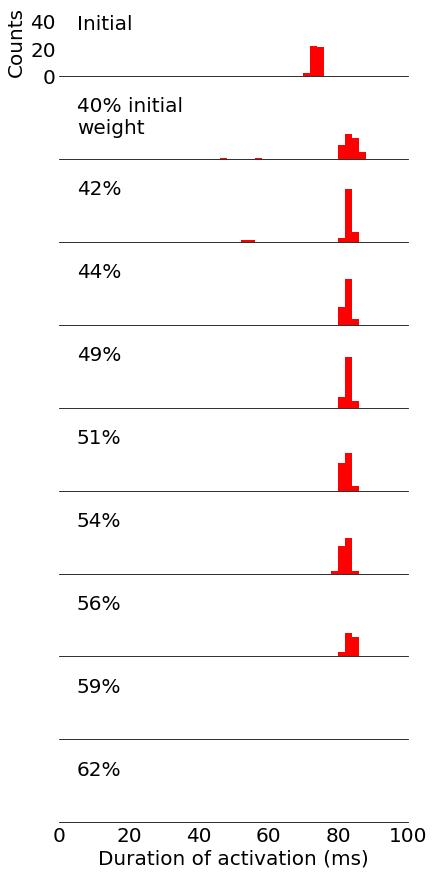

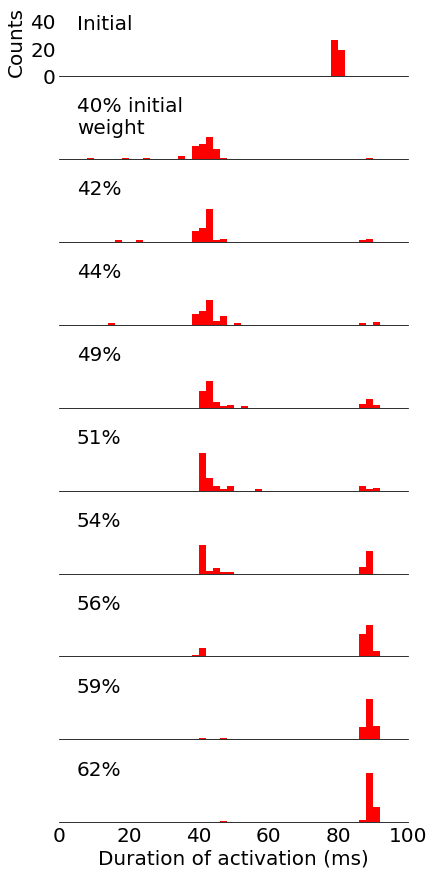

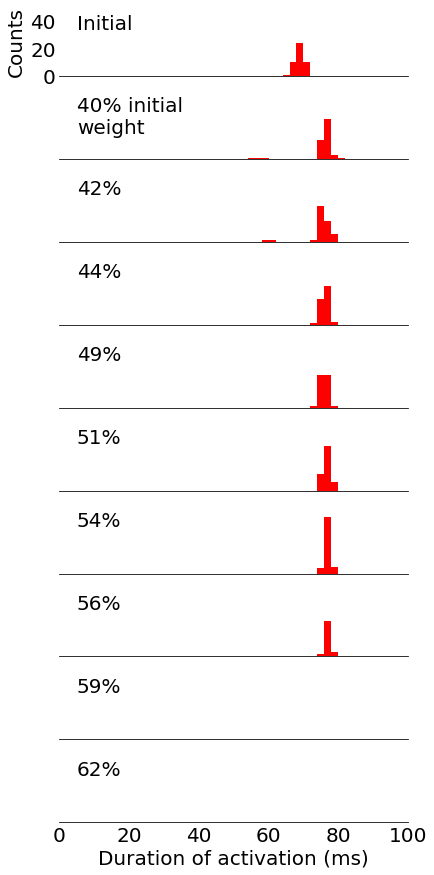

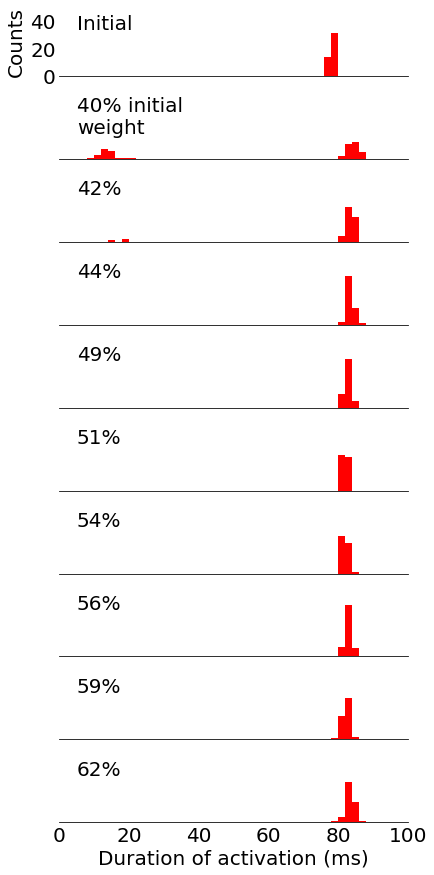

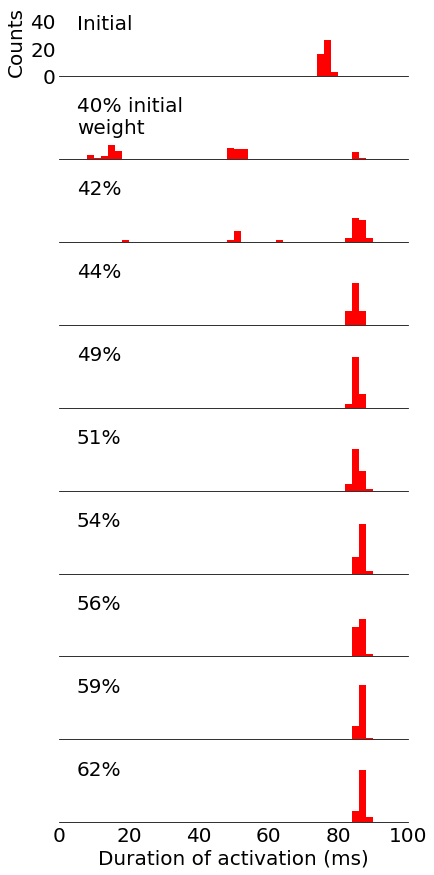

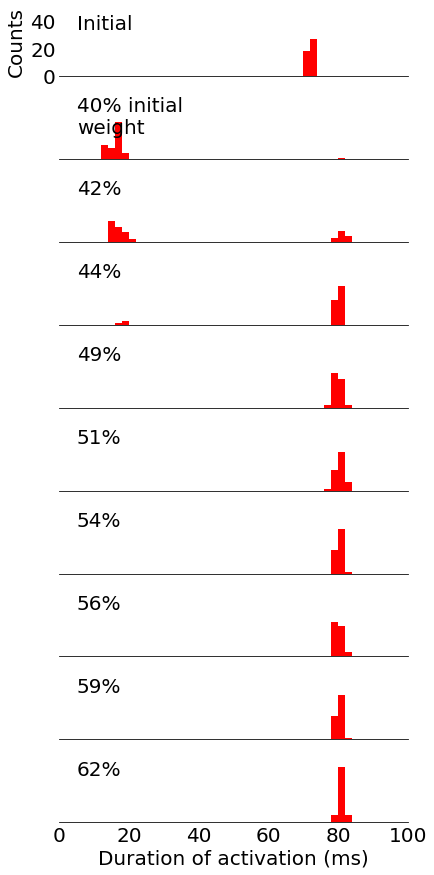

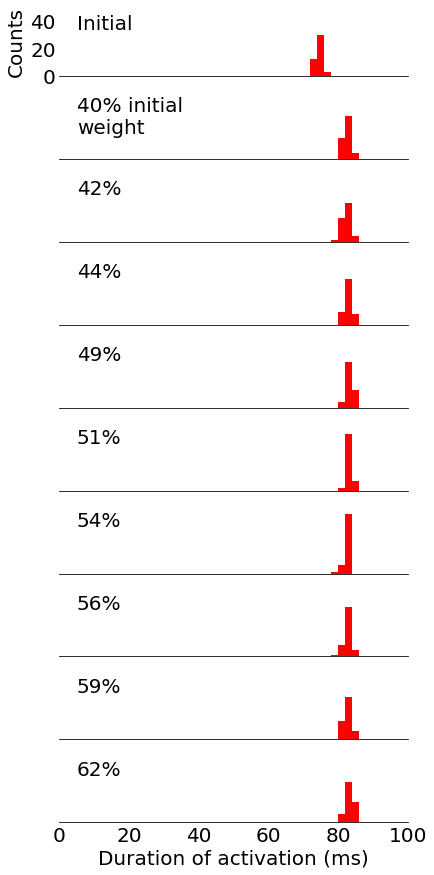

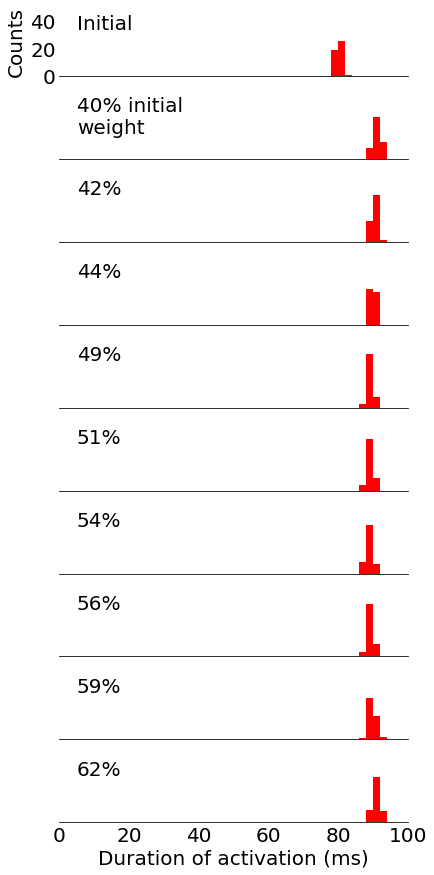

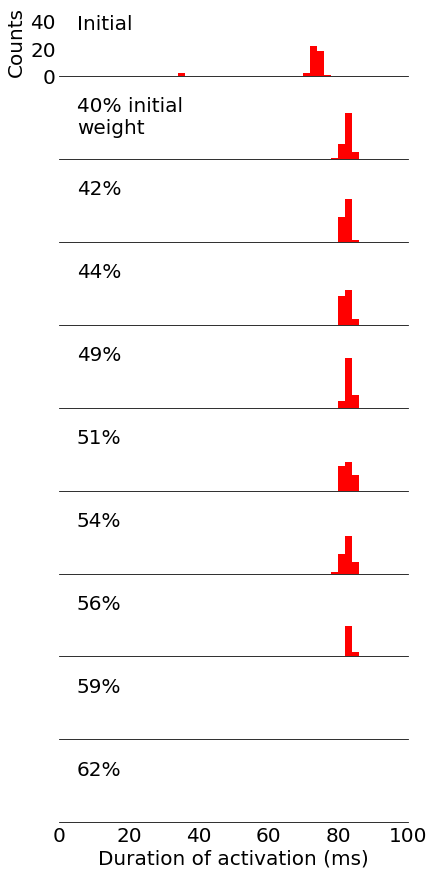

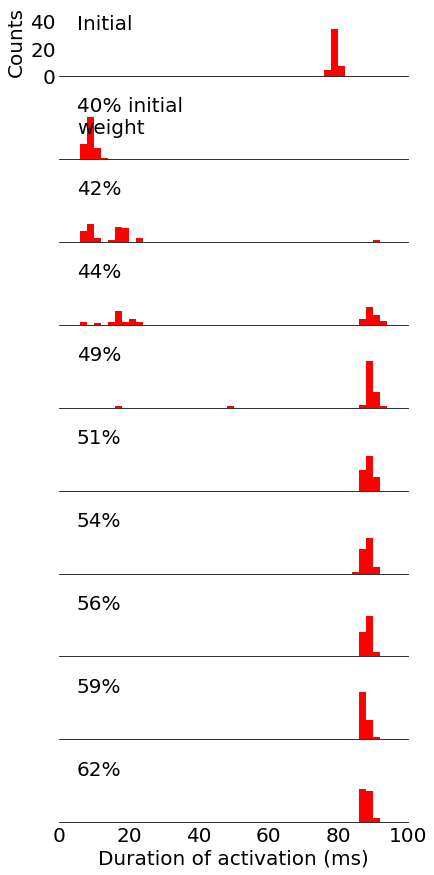

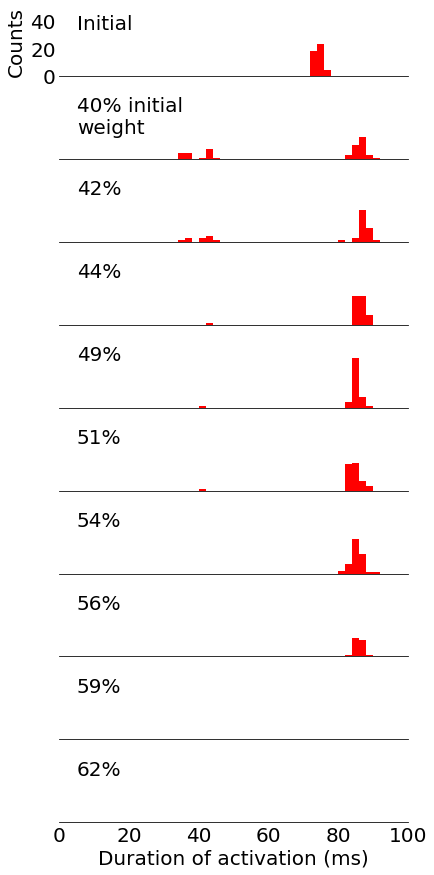

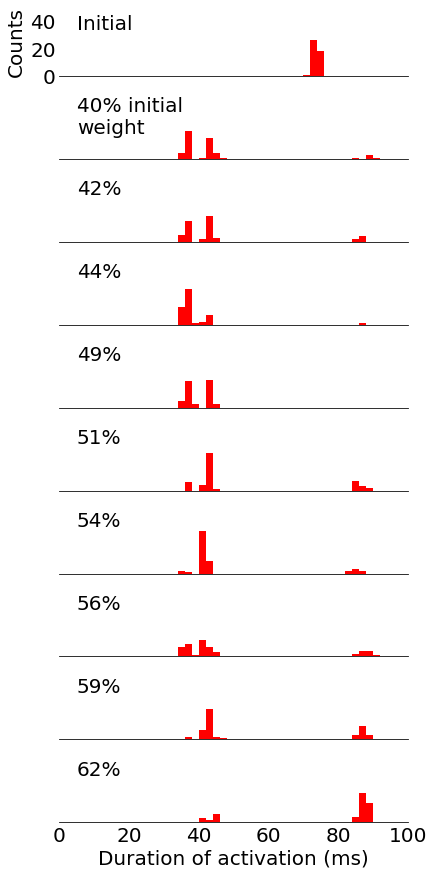

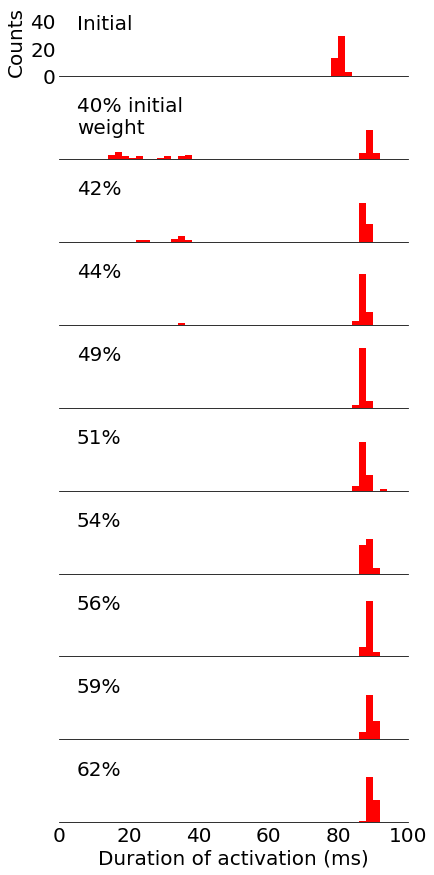

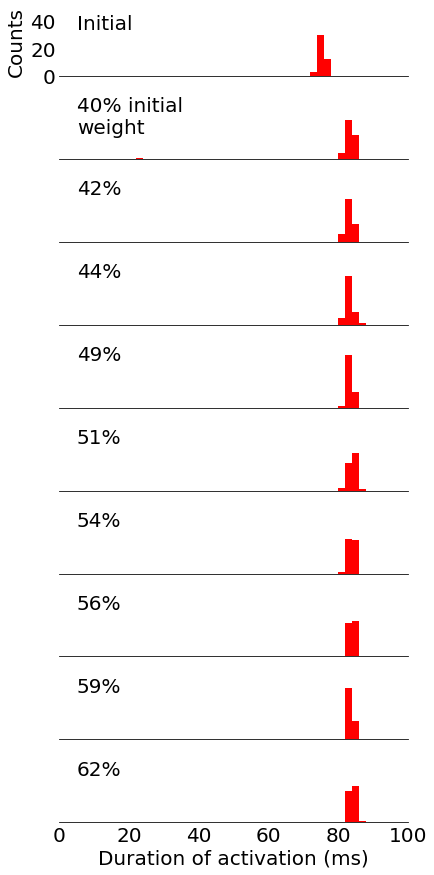

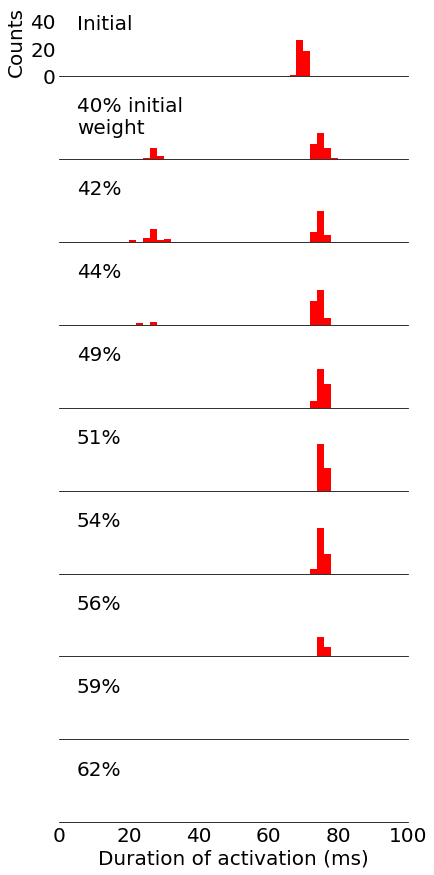

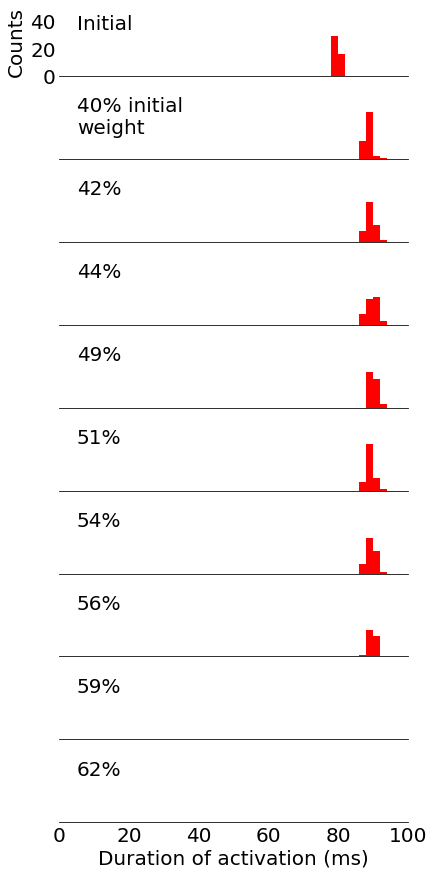

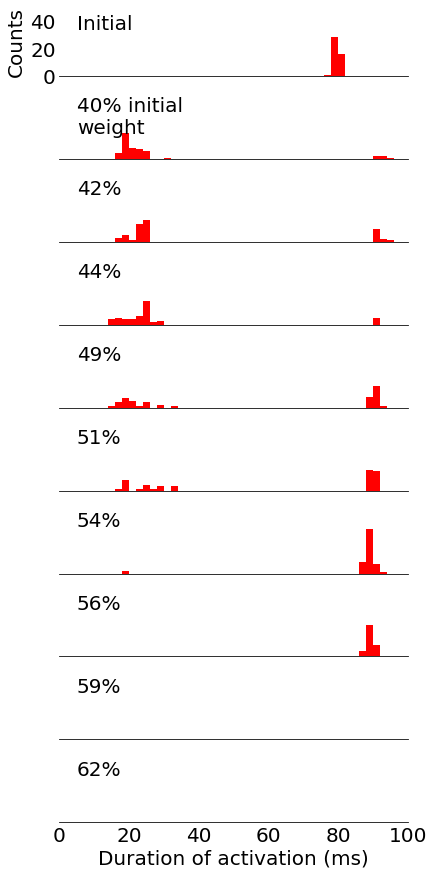

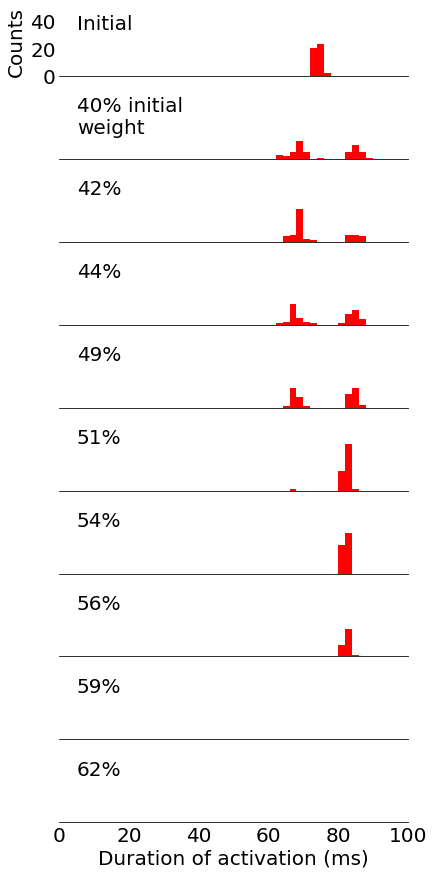

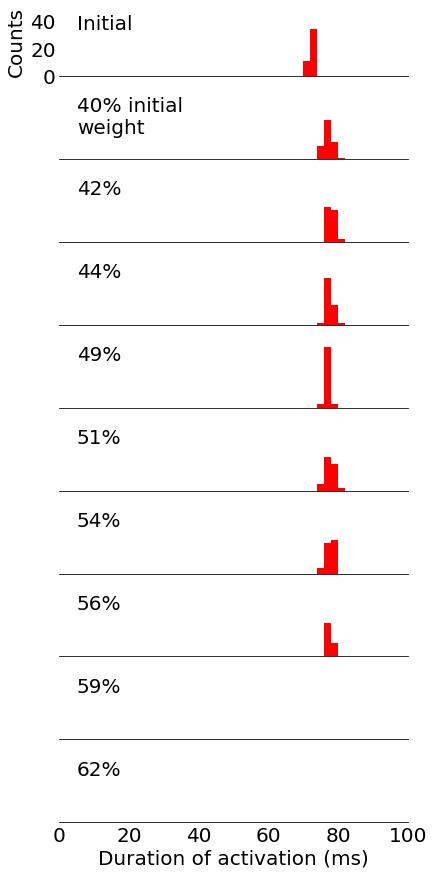

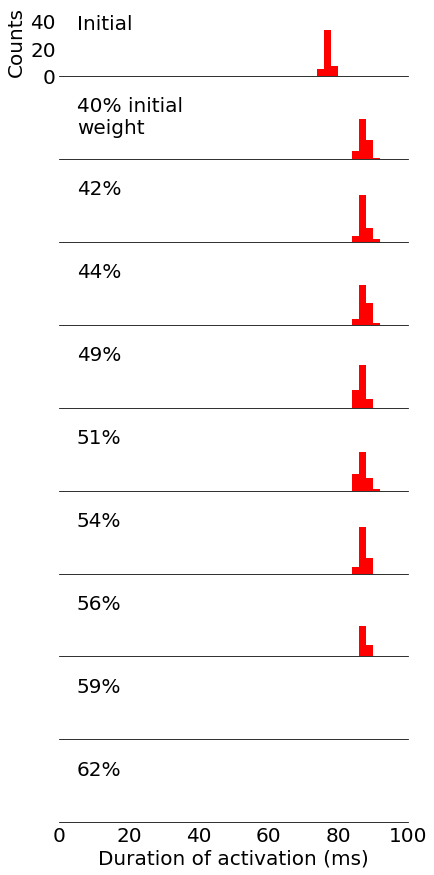

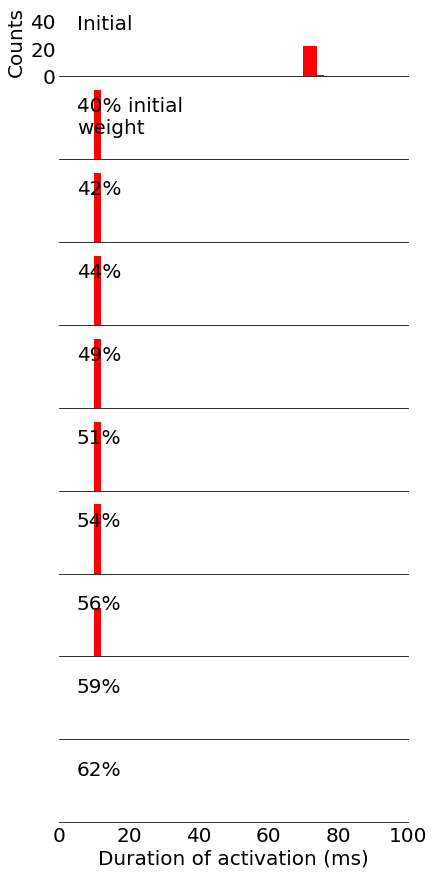

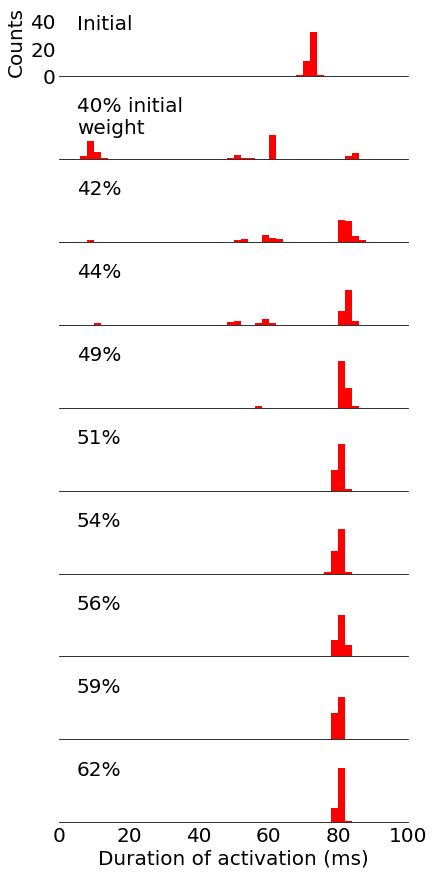

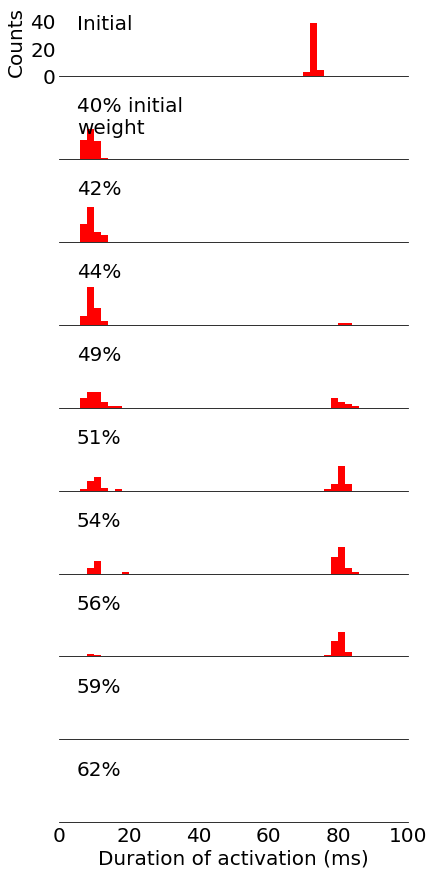

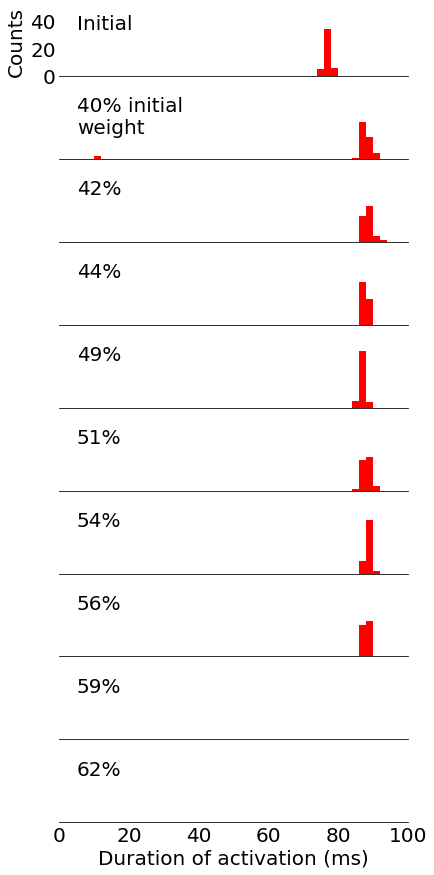

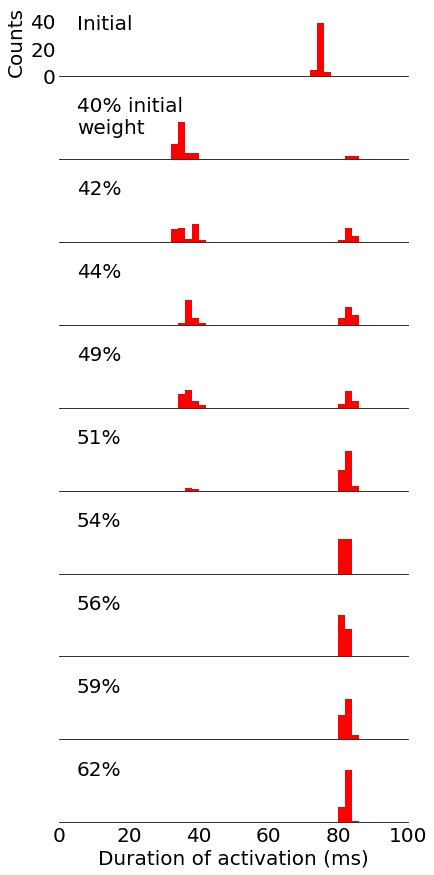

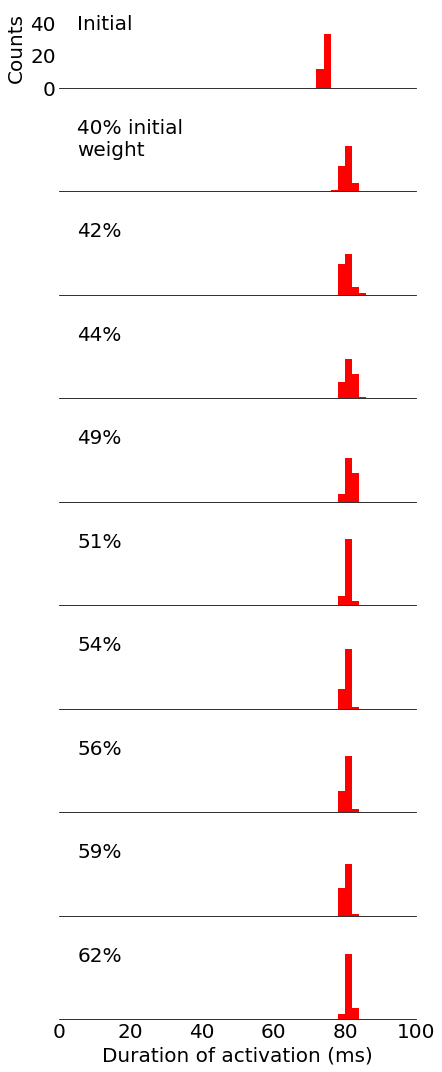

In [24]:
make_total_activity_plot([
    [''],
], [(5, 50)] + [(i, i + 50) for i in range(50, 500, 50)],
labels=[100, 40, 42, 44, 49, 51, 54, 56, 59, 62, 65, 68], ylim1=None, ylim2=None, ylabel1=None, ylabel2=None, tick_right=False, legend=True)

In [15]:
def make_figure_2_plot(names, labels, condition_colors, n_excs=[450], file_name_ext='', ylim1=None, ylim2=None,
                       ylabel1=None, ylabel2=None, timepoints=[], offsets=[], vertical_spacing=0.,
                       axs=None, fig=None, tick_right=True, legend=True):
    scale = 2.5
    
    if fig is None:
        fig, axs = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(6 * scale, 2.5 * scale))
    
    all_dirs = []
    for name in names:
        if type(name) is not list:
            name = [name]
        print(name)
        all_dirs.append([dirs for dirs in filter_list_by_name_frags(all_in_dir('./robustness'), name)])
        
    timepoints = np.array(timepoints)
        
    for idx, exp_dir_names in enumerate(all_dirs):
        all_weights_for_dir_name = []
        all_weights_e_i_for_dir_name = []
        
        for j, exp_dir_name in enumerate(exp_dir_names):
#             if exp_dir_name not in recovered_exp_names:
#                 continue

            print(exp_dir_name)
                    
            all_mean_incoming_summed_weights = []
            all_std_incoming_summed_weights = []
            all_mean_incoming_summed_weights_e_i = []
            all_std_incoming_summed_weights_e_i = []
            baseline_mean = None
            baseline_std = None
            baseline_mean_e_i = None
            baseline_std_e_i = None

            for i, data_load in load_exp_data(os.path.join('./robustness', exp_dir_name), n_exc=n_excs[idx], name_frags=[], new_cell_idx=200):
                if i not in timepoints:
                    continue
                data = data_load()
                
                all_mean_incoming_summed_weights.append(data['mean_incoming_summed_weights_e_e'])
                all_std_incoming_summed_weights.append(data['std_incoming_summed_weights_e_e'])
                all_mean_incoming_summed_weights_e_i.append(data['mean_incoming_summed_weights_e_i'])
                all_std_incoming_summed_weights_e_i.append(data['std_incoming_summed_weights_e_i'])

                if i == offsets[idx]:
                    baseline_mean = data['mean_incoming_summed_weights_e_e']
                    baseline_std = data['std_incoming_summed_weights_e_e']
                    baseline_mean_e_i = data['mean_incoming_summed_weights_e_i']
                    baseline_std_e_i = data['std_incoming_summed_weights_e_i']
                       
            all_mean_incoming_summed_weights = np.array(all_mean_incoming_summed_weights) / baseline_mean
            all_std_incoming_summed_weights = np.array(all_std_incoming_summed_weights) / baseline_mean
            all_mean_incoming_summed_weights_e_i = np.array(all_mean_incoming_summed_weights_e_i) / baseline_mean_e_i
            all_std_incoming_summed_weights_e_i = np.array(all_std_incoming_summed_weights_e_i) / baseline_mean_e_i
            
            if np.max(all_mean_incoming_summed_weights) < 8:
                all_weights_for_dir_name.append(all_mean_incoming_summed_weights)
                all_weights_e_i_for_dir_name.append(all_mean_incoming_summed_weights_e_i)
            
#                 axs[0].plot(timepoints[:len(all_mean_incoming_summed_weights)] * 10, all_mean_incoming_summed_weights, color=condition_colors[idx][0], lw=0.5, zorder=-1)
#                 axs[1].plot(timepoints[:len(all_mean_incoming_summed_weights_e_i)] * 10, all_mean_incoming_summed_weights_e_i, color=condition_colors[idx][1], lw=0.5, zorder=-1)

        
        if len(all_weights_for_dir_name) == 0:
            continue
        
        e_e_means = safe_apply_stat(all_weights_for_dir_name, np.mean)
        e_e_sems = safe_apply_stat(all_weights_for_dir_name, lambda x: np.std(x))
        e_i_means = safe_apply_stat(all_weights_e_i_for_dir_name, np.mean)
        e_i_sems = safe_apply_stat(all_weights_e_i_for_dir_name, lambda x: np.std(x) )

        y_disp = vertical_spacing * idx
        trimmed_timepoints = timepoints[:len(e_e_means)]

        axs[0].fill_between(
            trimmed_timepoints * 10,
            e_e_means - e_e_sems + y_disp,
            e_e_means + e_e_sems + y_disp,
            color=condition_colors[idx][0], alpha=0.2, zorder=0)
        axs[0].plot(trimmed_timepoints * 10, e_e_means + y_disp, lw=1.5, color=condition_colors[idx][0], label=labels[idx], zorder=0)
        axs[1].fill_between(
            trimmed_timepoints * 10,
            e_i_means - e_i_sems + y_disp,
            e_i_means + e_i_sems + y_disp,
            color=condition_colors[idx][1], alpha=0.2, zorder=-1)
        axs[1].plot(trimmed_timepoints * 10, e_i_means + y_disp, lw=1.5, color=condition_colors[idx][1], label=labels[idx], zorder=-1)

        if ylabel1 is None:    
            axs[0].set_ylabel(r'Mean E$\rightarrow$E summed' + '\nsynapse strength')
        else:
            axs[0].set_ylabel(ylabel1)
            
        if ylabel2 is None:  
            axs[1].set_ylabel(r'Mean E$\rightarrow$I summed' + '\nsynapse strength')
        else:
            axs[1].set_ylabel(ylabel2)
        if ylim1 is not None:
                axs[0].set_ylim(ylim1[0], ylim1[1])
        if ylim2 is not None:
                axs[1].set_ylim(ylim2[0], ylim2[1])
                
        y_ticks = []
        y_tick_labels = []
        for i in range(len(names)):
            y_ticks.append(vertical_spacing * i + 0.5)
            y_ticks.append(vertical_spacing * i + 1)
            y_ticks.append(vertical_spacing * i + 1.5)
            y_tick_labels.append(0.5)
            y_tick_labels.append(1)
            y_tick_labels.append(1.5)
                
        for i in range(2):
#             axs[i].set_xlim(10 * timepoints[0], 10 * timepoints[-1])
            axs[i].set_xlabel('Rendition number')
            if tick_right:
                axs[i].tick_params(right=True, labelright=True)
            set_font_size(axs[i], 14)
#             axs[i].set_yticks(y_ticks)
#             axs[i].set_yticklabels(y_tick_labels)
    if legend:
        axs[0].legend(loc='lower right')
    fig.tight_layout()
    save_fig(fig, './figures/paper/fig_2', f'mean_plot_{file_name_ext}.png')

In [18]:
def extract_weight_dist_stats(names, recovered_exp_names, timepoints, n_exc=300, new_cell_idx=200):
    all_dirs = []
    for name in names:
        if type(names) is list:
            all_dirs.append([dirs for dirs in filter_list_by_name_frags(all_in_dir('./robustness'), name)])
        else:
            all_dirs.append([dirs for dirs in filter_list_by_name_frags(all_in_dir('./robustness'), [name])])
    
    all_weight_dist_info = []
    all_summed_weights = []
    
    for i, exp_dir_names in enumerate(all_dirs):
        
        summed_weights_for_group = [[] for t in timepoints]
        summed_weights_for_group_perturbed = [[] for t in timepoints]
        weight_freqs_for_group = [[] for t in timepoints]
        weight_bins = [[] for t in timepoints]
        
        for j, exp_dir_name in enumerate(exp_dir_names):
#             if exp_dir_name not in recovered_exp_names:
#                 continue
            print(exp_dir_name)
            
            t_ctr = 0
            for k, data_load in load_exp_data(os.path.join('./robustness', exp_dir_name), name_frags=[], n_exc=n_exc, new_cell_idx=new_cell_idx):
                if k not in timepoints:
                    continue
                data = data_load()
                
                summed_incoming_weights = data['summed_incoming_weights_e_e']
                summed_weights_for_group[t_ctr].append(summed_incoming_weights)
                
                bins, freqs = bin_occurrences(summed_incoming_weights, max_val=0.0035, bin_size=0.00001)
                weight_bins[t_ctr] = bins
                weight_freqs_for_group[t_ctr].append(freqs)
                
                t_ctr += 1
        
        mean_weight_dists = []
        std_weight_dists = []
        summed_weight_bins = []
        
        mean_summed_incoming_weights = []
        std_summed_incoming_weights = []
        all_summed_incoming_weights = []
        
        all_summed_incoming_weights_perturbed = []
        
        for i_t, t in enumerate(timepoints):
            mean_weight_dists.append(np.nanmean(weight_freqs_for_group[i_t], axis=0))
            std_weight_dists.append(np.nanstd(weight_freqs_for_group[i_t], axis=0))
            summed_weight_bins.append(weight_bins[i_t])
            
            all_summed_incoming_weights.append(np.array(summed_weights_for_group[i_t]).flatten())
            mean_summed_incoming_weights.append(np.nanmean(summed_weights_for_group[i_t], axis=0).flatten())
            std_summed_incoming_weights.append(np.nanstd(summed_weights_for_group[i_t], axis=0).flatten())
                
        all_weight_dist_info.append({
                'mean_weight_dists': mean_weight_dists,
                'std_weight_dists': std_weight_dists,
                'summed_weight_bins': summed_weight_bins[0],
                'mean_summed_incoming_weights': mean_summed_incoming_weights,
                'std_summed_incoming_weights': std_summed_incoming_weights,
                'all_summed_incoming_weights': all_summed_incoming_weights,
        })
    return all_weight_dist_info

In [22]:
all_weight_dist_info_1 = extract_weight_dist_stats([
    ['summed_bound_2022-07-09--18:42--51:6535']
], [], [39, 40, 250], n_exc=200)

summed_bound_2022-07-09--18:42--51:6535


In [14]:
all_weight_dist_info_2 = extract_weight_dist_stats([
    ['DROP_SEV_0.5', 'CONDITION_no_repl_no_syn_PER_SILENT_0.5_2022'],
], recovered_exp_names, [99, 150, 250], n_exc=200)

secreted__SEED_2007_W_E_E_0.0012_W_E_I_7e-05_W_I_E_6e-05_DROP_SEV_0.5_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.5_2022-06-21--17:39--02:6435
secreted__SEED_2002_W_E_E_0.0012_W_E_I_7e-05_W_I_E_6e-05_DROP_SEV_0.5_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.5_2022-06-21--17:39--02:6544
secreted__SEED_2008_W_E_E_0.0012_W_E_I_7e-05_W_I_E_6e-05_DROP_SEV_0.5_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.5_2022-06-21--17:39--02:2681
secreted__SEED_2019_W_E_E_0.0012_W_E_I_7e-05_W_I_E_6e-05_DROP_SEV_0.5_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.5_2022-06-21--17:39--01:9033
secreted__SEED_2001_W_E_E_0.0012_W_E_I_7e-05_W_I_E_6e-05_DROP_SEV_0.5_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.5_2022-06-21--17:39--02:1671
secreted__SEED_2013_W_E_E_0.0012_W_E_I_7e-05_W_I_E_6e-05_DROP_SEV_0.5_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.5_2022-06-21--17:39--02:675

In [34]:
def make_interpolated_violin_plot_and_weight_traj(all_weight_dist_info, names, dist_timepoints, n_excs=[300], new_cell_idx=200, exc_cell_color='black', inh_cell_color='blue', ylim=(0, 1)):
    scale = 1.3
    fig, axs = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(8 * scale, 4 * scale))
    plt.locator_params(axis='x', nbins=6)

    dist_timepoints = np.array(dist_timepoints)
    colors = get_equally_spaced_colors(3, cmap='winter')

    for k, dist_data_for_name in enumerate(all_weight_dist_info):
        if len(dist_data_for_name) > 0:
            axs[1].set_ylabel('Summed synaptic strength')
            axs[1].yaxis.set_label_position('right')
            axs[1].yaxis.tick_right()
            axs[0].set_ylim(0, 6)
            axs[1].set_ylim(ylim)
            
            axs[0].xaxis.set_major_locator(plt.MaxNLocator(5))
                        
            widths = 0.9
            
            mean_initial_summed_incoming_weight = np.mean(dist_data_for_name['all_summed_incoming_weights'][0])
            normalized_data = dist_data_for_name['all_summed_incoming_weights'] / mean_initial_summed_incoming_weight
            
#             normalized_data = [nd[nd < 15] for nd in normalized_data]
            
            parts = axs[1].violinplot(normalized_data, positions= 1 + np.arange(len(normalized_data)), showmeans=False, showextrema=False, widths=widths)
            for pc in parts['bodies']:
                pc.set_facecolor(exc_cell_color)
    #             pc.set_edgecolor('black')
                pc.set_alpha(0.15)

            num_to_sample = 30
            for i, dist_data in enumerate(dist_data_for_name['all_summed_incoming_weights']):
                indices_to_show = np.arange(len(normalized_data[i]))
                np.random.shuffle(indices_to_show)
                indices_to_show = indices_to_show[:num_to_sample]
                
                axs[1].scatter(i + 1 + np.random.normal(size=num_to_sample, scale=0.05), normalized_data[i][indices_to_show],
                            s=10, color=exc_cell_color, zorder=3)
            axs[1].set_xticks([1, 2, 3])
            axs[1].set_xticklabels([
                r'$1000^{th}$' + '\nrendition',
                r'$1500^{th}$' + '\nrendition',
                r'$2500^{th}$'  + '\nrendition'
            ])
            axs[1].set_ylabel('Normalized summed \nsynaptic strength')
        
            axs[0].spines['top'].set_visible(False)
            axs[0].spines['right'].set_visible(False)
            axs[1].spines['top'].set_visible(False)
            axs[1].spines['left'].set_visible(False)
        
#             axs[0].tick_params(right=True, labelright=True)

            timepoints_start = dist_timepoints[0] - 10 if dist_timepoints[0] - 10 > 0 else 0
            timepoints = np.arange(timepoints_start, dist_timepoints[-1] + 30)

            make_figure_2_plot(names, labels=['', ''],
            condition_colors=[('black', 'blue')], timepoints=timepoints, offsets=dist_timepoints[0] * np.ones(20), vertical_spacing=0.,
            file_name_ext='', axs=[axs[0], axs[0]], fig=fig, tick_right=False, legend=False, ylabel2='Normalized summed \nsynapse strength', n_excs=n_excs)
            set_font_size(axs[0], 14)
            set_font_size(axs[1], 14)
            
            save_fig(fig, './figures/paper/weight_trajectories', f'{k}.svg')

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


['summed_bound_2022-07-09--18:42--51:6535']
summed_bound_2022-07-09--18:42--51:6535


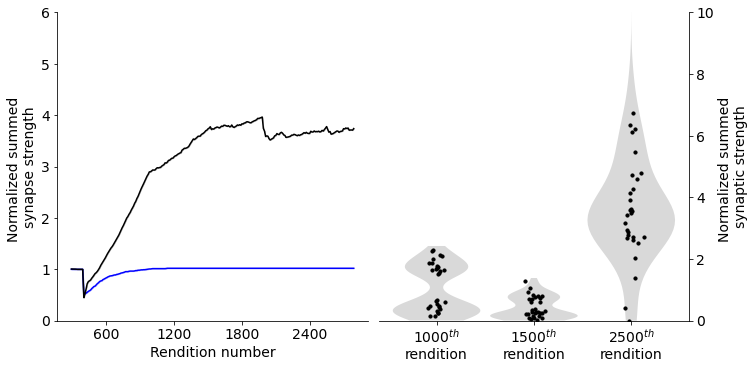

In [35]:
make_interpolated_violin_plot_and_weight_traj(all_weight_dist_info_1, [
    ['summed_bound_2022-07-09--18:42--51:6535'],
], dist_timepoints=[39, 40, 250], n_excs=[200], ylim=(0, 10))


['DROP_SEV_0.5', 'CONDITION_no_repl_no_syn_PER_SILENT_0.5_2022']
secreted__SEED_2007_W_E_E_0.0012_W_E_I_7e-05_W_I_E_6e-05_DROP_SEV_0.5_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.5_2022-06-21--17:39--02:6435
secreted__SEED_2002_W_E_E_0.0012_W_E_I_7e-05_W_I_E_6e-05_DROP_SEV_0.5_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.5_2022-06-21--17:39--02:6544
secreted__SEED_2008_W_E_E_0.0012_W_E_I_7e-05_W_I_E_6e-05_DROP_SEV_0.5_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.5_2022-06-21--17:39--02:2681
secreted__SEED_2019_W_E_E_0.0012_W_E_I_7e-05_W_I_E_6e-05_DROP_SEV_0.5_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.5_2022-06-21--17:39--01:9033
secreted__SEED_2001_W_E_E_0.0012_W_E_I_7e-05_W_I_E_6e-05_DROP_SEV_0.5_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.5_2022-06-21--17:39--02:1671
secreted__SEED_2013_W_E_E_0.0012_W_E_I_7e-05_W_I_E_6e-05_DROP_SEV_0.5_COMP_MECH_secreted_regulation_

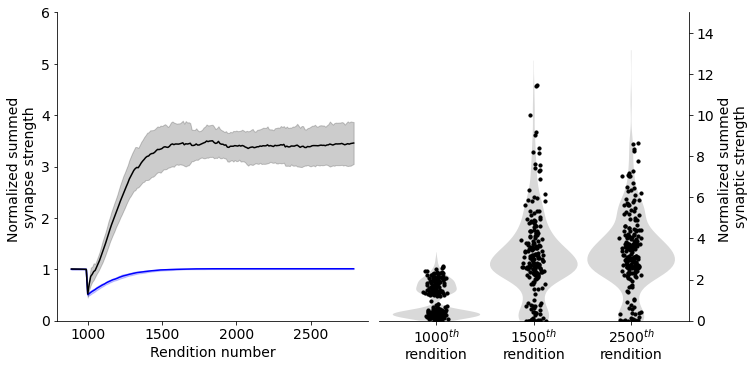

In [19]:
make_interpolated_violin_plot_and_weight_traj(all_weight_dist_info_2, [
    ['DROP_SEV_0.5', 'CONDITION_no_repl_no_syn_PER_SILENT_0.5_2022'],
], [99, 150, 250], n_excs=[200, 200], ylim=(0, 15))

In [21]:
def find_sequence_end(trace, t):
    t_ctr = len(trace) - 1
    while trace[t_ctr] == 0:
        t_ctr -= 1
    return t[t_ctr + 1]

def find_sequence_beginning(trace, t):
    t_ctr = 0
    while trace[t_ctr] == 0:
        t_ctr += 1
    return t[t_ctr - 1]

def find_seq_duration(trace, t):
    return find_sequence_end(trace, t) - find_sequence_beginning(trace, t)

def make_duration_graphs(name, timepoints=[0, 72, 73], n_exc=450, new_cell_idx=None):
    if type(name) is list:
        all_dirs = filter_list_by_name_frags(all_in_dir('./robustness'), name)
    else:
        all_dirs = filter_list_by_name_frags(all_in_dir('./robustness'), [name])
       
    scale = 0.8
    n_plots = 20
    fig = plt.figure(constrained_layout=True, figsize=(7 * scale, 5 * n_plots * scale))
    gs = gridspec.GridSpec(ncols=1, nrows=n_plots, figure=fig)
    axs = [fig.add_subplot(gs[i]) for i in range(n_plots)]
    
    for d_idx, exp_dir_name in enumerate(sorted(all_dirs)):
        j = 0
        
        old_activity_durations = []
        total_activity_durations = []
        
#         if d_idx > 3:
#             continue

        for i, load_data in load_exp_data(os.path.join('./robustness', exp_dir_name), reverse=False, n_exc=n_exc, new_cell_idx=new_cell_idx):
            if j < len(timepoints) and i == timepoints[j]:
#                 print(j, timepoints[j])
                data = load_data()
                if 'exc_raster_unperturbed' in data:
                    exc_raster = data['exc_raster_unperturbed']
                else:
                    exc_raster = data['exc_raster']
                
                exc_raster_old = exc_raster[:, exc_raster[1, :] < new_cell_idx]
                exc_raster_new = exc_raster[:, exc_raster[1, :] >= new_cell_idx]
                    
                inh_raster = data['inh_raster']
                
                t, e_old_activity_trace = sliding_window_activity(exc_raster_old, 10e-3, dt, (0, 0.24))
                t, e_new_activity_trace = sliding_window_activity(exc_raster_new, 10e-3, dt, (0, 0.24))
                t, i_activity_trace = sliding_window_activity(inh_raster, 10e-3, dt, (0, 0.24))
                
                t = 1000 * t
                
                e_old_duration = find_seq_duration(e_old_activity_trace, t)
                e_total_duration = find_seq_duration(e_old_activity_trace + e_new_activity_trace, t)
                
                
                old_activity_durations.append(e_old_duration)
                total_activity_durations.append(e_total_duration)
                
                j += 1
        
        axs[d_idx].plot(timepoints[:len(old_activity_durations)], old_activity_durations, lw=0.5, c='black')
        axs[d_idx].plot(timepoints[:len(total_activity_durations)], total_activity_durations, lw=0.5, c='purple')
        
        axs[d_idx].set_ylabel('Duration (ms)')
        axs[d_idx].set_xlabel('Rendition No.')
        axs[d_idx].spines['right'].set_visible(False)
        axs[d_idx].spines['top'].set_visible(False)
        plt.locator_params(axis='y', nbins=6)

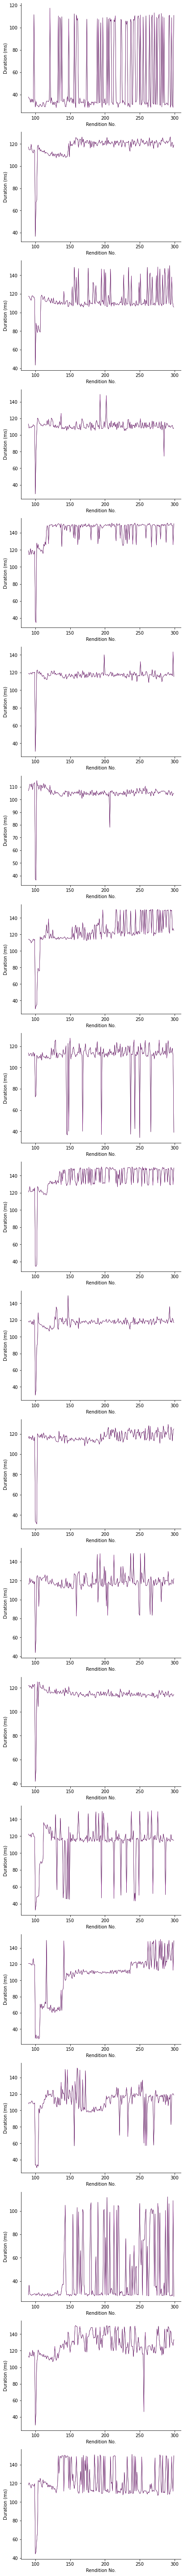

In [22]:
make_duration_graphs(['DROP_SEV_0.5', 'CONDITION_no_repl_no_syn_PER_SILENT_0.5_2022'],
                           timepoints=np.arange(90, 300), n_exc=200, new_cell_idx=200)

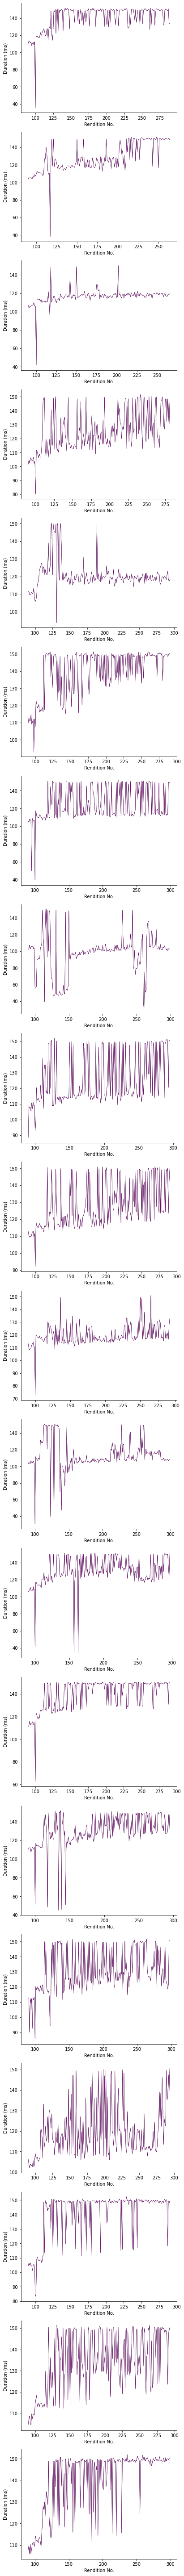

In [23]:
make_duration_graphs(['low_growth', 'DROP_SEV_0.5', 'CONDITION_all_PER_SILENT_0_2022'],
                           timepoints=np.arange(90, 300), n_exc=300, new_cell_idx=300)

In [81]:
def make_weight_entropy_plot(names, labels, condition_colors, n_excs=[450], file_name_ext='', ylim1=None, ylim2=None,
                       ylabel1=None, ylabel2=None, timepoints=[], offsets=[], vertical_spacing=0.,
                       axs=None, fig=None, tick_right=True, legend=True):
    scale = 2.5
    
    if fig is None:
        fig, axs = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(6 * scale, 2.5 * scale))
    
    all_dirs = []
    for name in names:
        if type(name) is not list:
            name = [name]
        print(name)
        all_dirs.append([dirs for dirs in filter_list_by_name_frags(all_in_dir('./robustness'), name)])
        
    timepoints = np.array(timepoints)
        
    for idx, exp_dir_names in enumerate(all_dirs):
        all_weight_entropies_for_dir_name = []
        
        for j, exp_dir_name in enumerate(exp_dir_names):
            print(exp_dir_name)
            
            if j >= 10:
                continue
            
            all_weight_entropies = []

            for i, data_load in load_exp_data(os.path.join('./robustness', exp_dir_name), n_exc=n_excs[idx], name_frags=[]):
                if i not in timepoints:
                    continue
                data = data_load()
                
                w_r_e_e = data['w_r_e'][:n_excs[idx], :n_excs[idx]]
                if 'surviving_cell_mask'in data:
                    surviving_cell_mask = data['surviving_cell_mask']
                    w_r_e_e = w_r_e_e[surviving_cell_mask, :]
                normed_w_r_e_e = np.array(w_r_e_e.todense()) / w_r_e_e.sum(axis=1)
                normed_w_r_e_e = normed_w_r_e_e[np.logical_and(~np.isnan(normed_w_r_e_e), normed_w_r_e_e > 0)]
                log_w_r_e_e = np.log(normed_w_r_e_e)
                
                weight_entropy = -1 * np.nanmean([np.dot(normed_w_r_e_e[m,:], log_w_r_e_e[m,:].T) for m in range(normed_w_r_e_e.shape[0])])
                                   
                all_weight_entropies.append(weight_entropy)
            
            all_weight_entropies_for_dir_name.append(all_weight_entropies)
            
        if len(all_weight_entropies_for_dir_name) == 0:
            continue
        
        means = safe_apply_stat(all_weight_entropies_for_dir_name, np.mean)
        sems = safe_apply_stat(all_weight_entropies_for_dir_name, lambda x: np.std(x) / np.sqrt(len(x)))

        y_disp = vertical_spacing * idx

        axs[0].fill_between(
            timepoints * 10,
            means - sems + y_disp,
            means + sems + y_disp,
            color=condition_colors[idx][0], alpha=0.2, zorder=0)
        axs[0].plot(timepoints * 10, means + y_disp, lw=1.5, color=condition_colors[idx][0], label=labels[idx], zorder=0)
        

        if ylabel1 is None:    
            axs[0].set_ylabel(r'Mean E$\rightarrow$E weight entropy')
        else:
            axs[0].set_ylabel(ylabel1)
            
        if ylabel2 is None:  
            axs[1].set_ylabel(r'Mean E$\rightarrow$I summed' + '\nsynapse strength')
        else:
            axs[1].set_ylabel(ylabel2)
        if ylim1 is not None:
                axs[0].set_ylim(ylim1[0], ylim1[1])
        if ylim2 is not None:
                axs[1].set_ylim(ylim2[0], ylim2[1])
                
        y_ticks = []
        y_tick_labels = []
        for i in range(len(names)):
            y_ticks.append(vertical_spacing * i + 0.5)
            y_ticks.append(vertical_spacing * i + 1)
            y_ticks.append(vertical_spacing * i + 1.5)
            y_tick_labels.append(0.5)
            y_tick_labels.append(1)
            y_tick_labels.append(1.5)
                
        for i in range(2):
            axs[i].set_xlim(10 * timepoints[0], 10 * timepoints[-1])
            axs[i].set_xlabel('Rendition number')
            if tick_right:
                axs[i].tick_params(right=True, labelright=True)
            set_font_size(axs[i], 14)
#             axs[i].set_yticks(y_ticks)
#             axs[i].set_yticklabels(y_tick_labels)
    if legend:
        axs[0].legend(loc='lower right')
    fig.tight_layout()
    save_fig(fig, './figures/paper/fig_2', f'mean_plot_{file_name_ext}.png')

['stdp_rand_syn', 'all']
['stdp_rand_syn', 'no_repl_20']
['stdp_rand_syn', 'no_repl_no_syn']
stdp_rand_syn_slow_8__DROP_SEV_0.5_SEED_2012_W_I_E_6e-05_W_E_I_7e-05_W_E_E_0.0012_CONDITION_all_2022-05-09--22:42--20:0713
stdp_rand_syn_slow_8__DROP_SEV_0.5_SEED_2005_W_I_E_6e-05_W_E_I_7e-05_W_E_E_0.0012_CONDITION_all_2022-05-09--22:42--20:1805
stdp_rand_syn_slow_8__DROP_SEV_0.5_SEED_2007_W_I_E_6e-05_W_E_I_7e-05_W_E_E_0.0012_CONDITION_all_2022-05-09--22:42--20:6435
stdp_rand_syn_slow_8__DROP_SEV_0.5_SEED_2013_W_I_E_6e-05_W_E_I_7e-05_W_E_E_0.0012_CONDITION_all_2022-05-09--22:42--20:6753
stdp_rand_syn_slow_8__DROP_SEV_0.5_SEED_2016_W_I_E_6e-05_W_E_I_7e-05_W_E_E_0.0012_CONDITION_all_2022-05-09--22:42--20:8966
stdp_rand_syn_slow_8__DROP_SEV_0.5_SEED_2011_W_I_E_6e-05_W_E_I_7e-05_W_E_E_0.0012_CONDITION_all_2022-05-09--22:42--20:9272
stdp_rand_syn_slow_8__DROP_SEV_0.5_SEED_2017_W_I_E_6e-05_W_E_I_7e-05_W_E_E_0.0012_CONDITION_all_2022-05-09--22:42--20:0209
stdp_rand_syn_slow_8__DROP_SEV_0.5_SEED_2018_W

stdp_rand_syn_slow_8__DROP_SEV_0.5_SEED_2008_W_I_E_6e-05_W_E_I_7e-05_W_E_E_0.0012_CONDITION_no_repl_no_syn_2022-05-09--22:42--20:2681
stdp_rand_syn_slow_8__DROP_SEV_0.5_SEED_2003_W_I_E_6e-05_W_E_I_7e-05_W_E_E_0.0012_CONDITION_no_repl_no_syn_2022-05-09--22:42--20:4922
stdp_rand_syn_slow_8__DROP_SEV_0.5_SEED_2018_W_I_E_6e-05_W_E_I_7e-05_W_E_E_0.0012_CONDITION_no_repl_no_syn_2022-05-09--22:42--20:8822
stdp_rand_syn_slow_8__DROP_SEV_0.5_SEED_2001_W_I_E_6e-05_W_E_I_7e-05_W_E_E_0.0012_CONDITION_no_repl_no_syn_2022-05-09--22:42--20:1671
stdp_rand_syn_slow_8__DROP_SEV_0.5_SEED_2013_W_I_E_6e-05_W_E_I_7e-05_W_E_E_0.0012_CONDITION_no_repl_no_syn_2022-05-09--22:42--20:6753
stdp_rand_syn_slow_8__DROP_SEV_0.5_SEED_2019_W_I_E_6e-05_W_E_I_7e-05_W_E_E_0.0012_CONDITION_no_repl_no_syn_2022-05-09--22:42--20:9033
stdp_rand_syn_slow_8__DROP_SEV_0.5_SEED_2004_W_I_E_6e-05_W_E_I_7e-05_W_E_E_0.0012_CONDITION_no_repl_no_syn_2022-05-09--22:42--20:5876
stdp_rand_syn_slow_8__DROP_SEV_0.5_SEED_2015_W_I_E_6e-05_W_E_I

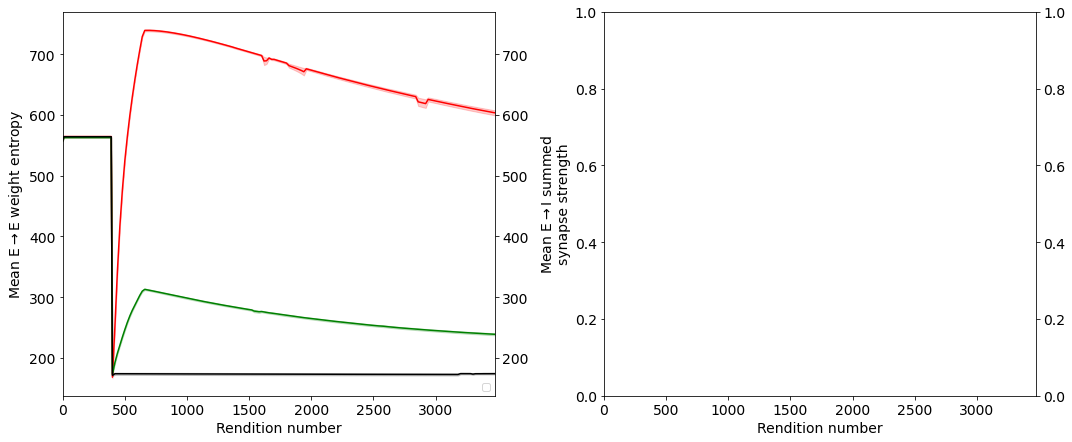

In [84]:
make_weight_entropy_plot([
    ['stdp_rand_syn', 'all'],
    ['stdp_rand_syn', 'no_repl_20'],
    ['stdp_rand_syn', 'no_repl_no_syn'],
], labels=[''] * 20, condition_colors=[
    ('red', 'red'),
    ('green', 'green'),
    ('black', 'black'),
],
timepoints=np.concatenate([np.arange(40), np.arange(40, 350, 2)]), offsets=39 * np.ones(20), n_excs=[450, 300, 300])

In [270]:
def make_timing_precision_graphs(names, timepoints=[600], n_exc=300, new_cell_idx=200):
    all_dirs = []
    for name in names:
        if type(names) is list:
            all_dirs.append([dirs for dirs in filter_list_by_name_frags(all_in_dir('./robustness'), name)])
        else:
            all_dirs.append([dirs for dirs in filter_list_by_name_frags(all_in_dir('./robustness'), [name])])
    
    for i, exp_dir_names in enumerate(all_dirs):   
        scale = 1.1
        fig = plt.figure(constrained_layout=True, figsize=(5 * scale, 5 * scale))
        gs = gridspec.GridSpec(ncols=1, nrows=2, figure=fig)
        axs = [fig.add_subplot(gs[:, 0])]
        
        for j, exp_dir_name in enumerate(exp_dir_names):
            if exp_dir_name not in recovered_exp_names:
                continue
            print(exp_dir_name)
            j = 0

            all_first_spk_times = []

            for i, load_data in load_exp_data(os.path.join('./robustness', exp_dir_name), n_exc=n_exc):
                if j < len(timepoints) and i == timepoints[j]:
                    data = load_data()
                    first_spk_times = data['first_spk_times']
                    original_surviving_mask = np.arange(n_exc) < new_cell_idx     
                    if 'surviving_cell_mask' in data:
                        original_surviving_mask = np.logical_and(original_surviving_mask, data['surviving_cell_mask']).astype(bool)
                    first_spk_times = data['first_spk_times'][original_surviving_mask]
                    all_first_spk_times.append(first_spk_times)
                    j += 1
            
            all_first_spk_times = np.stack(all_first_spk_times)
            all_nan_means = np.nanmean(all_first_spk_times, axis=0)
            all_nan_stds = np.nanstd(all_first_spk_times, axis=0)

            axs[0].scatter(all_nan_means, all_nan_stds, s=2, c='black', zorder=0, alpha=1)

        set_font_size(axs[0], 16)
        axs[0].spines['right'].set_visible(False)
        axs[0].spines['top'].set_visible(False)

        axs[0].set_xlabel('Firing time (s)')
        axs[0].set_ylabel('First spike STD (s)')

        axs[0].set_ylim(0, 0.0025)
        axs[0].set_xlim(0.05)

secreted_low_growth__SEED_2009_W_E_E_0.0012_W_E_I_7e-05_W_I_E_6e-05_DROP_SEV_0.5_COMP_MECH_secreted_regulation_CONDITION_no_repl_PER_SILENT_0_2022-06-21--23:32--32:0602
secreted_low_growth__SEED_2005_W_E_E_0.0012_W_E_I_7e-05_W_I_E_6e-05_DROP_SEV_0.5_COMP_MECH_secreted_regulation_CONDITION_no_repl_PER_SILENT_0_2022-06-21--23:32--32:1805
secreted_low_growth__SEED_2000_W_E_E_0.0012_W_E_I_7e-05_W_I_E_6e-05_DROP_SEV_0.5_COMP_MECH_secreted_regulation_CONDITION_no_repl_PER_SILENT_0_2022-06-21--23:32--32:5704
secreted_low_growth__SEED_2004_W_E_E_0.0012_W_E_I_7e-05_W_I_E_6e-05_DROP_SEV_0.5_COMP_MECH_secreted_regulation_CONDITION_no_repl_PER_SILENT_0_2022-06-21--23:32--32:5876
secreted_low_growth__SEED_2018_W_E_E_0.0012_W_E_I_7e-05_W_I_E_6e-05_DROP_SEV_0.5_COMP_MECH_secreted_regulation_CONDITION_no_repl_PER_SILENT_0_2022-06-21--23:32--57:8822
secreted_low_growth__SEED_2014_W_E_E_0.0012_W_E_I_7e-05_W_I_E_6e-05_DROP_SEV_0.5_COMP_MECH_secreted_regulation_CONDITION_no_repl_PER_SILENT_0_2022-06-21--2

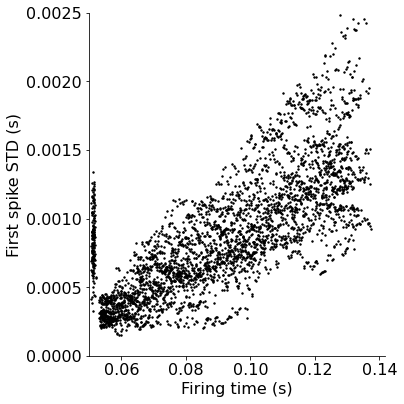

In [271]:
make_timing_precision_graphs([
     ['low_growth', 'DROP_SEV_0.5', 'CONDITION_no_repl_PER_SILENT_0_2022'],
],  np.arange(80, 89), n_exc=200)


secreted_low_growth__SEED_2009_W_E_E_0.0012_W_E_I_7e-05_W_I_E_6e-05_DROP_SEV_0.5_COMP_MECH_secreted_regulation_CONDITION_no_repl_PER_SILENT_0_2022-06-21--23:32--32:0602
secreted_low_growth__SEED_2005_W_E_E_0.0012_W_E_I_7e-05_W_I_E_6e-05_DROP_SEV_0.5_COMP_MECH_secreted_regulation_CONDITION_no_repl_PER_SILENT_0_2022-06-21--23:32--32:1805
secreted_low_growth__SEED_2000_W_E_E_0.0012_W_E_I_7e-05_W_I_E_6e-05_DROP_SEV_0.5_COMP_MECH_secreted_regulation_CONDITION_no_repl_PER_SILENT_0_2022-06-21--23:32--32:5704
secreted_low_growth__SEED_2004_W_E_E_0.0012_W_E_I_7e-05_W_I_E_6e-05_DROP_SEV_0.5_COMP_MECH_secreted_regulation_CONDITION_no_repl_PER_SILENT_0_2022-06-21--23:32--32:5876
secreted_low_growth__SEED_2018_W_E_E_0.0012_W_E_I_7e-05_W_I_E_6e-05_DROP_SEV_0.5_COMP_MECH_secreted_regulation_CONDITION_no_repl_PER_SILENT_0_2022-06-21--23:32--57:8822
secreted_low_growth__SEED_2014_W_E_E_0.0012_W_E_I_7e-05_W_I_E_6e-05_DROP_SEV_0.5_COMP_MECH_secreted_regulation_CONDITION_no_repl_PER_SILENT_0_2022-06-21--2

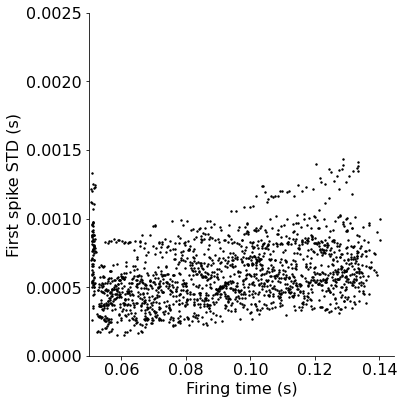

In [272]:
make_timing_precision_graphs([
     ['low_growth', 'DROP_SEV_0.5', 'CONDITION_no_repl_PER_SILENT_0_2022'],
],  np.arange(250, 260), n_exc=200)

secreted__SEED_2007_W_E_E_0.0012_W_E_I_7e-05_W_I_E_6e-05_DROP_SEV_0.5_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.5_2022-06-21--17:39--02:6435
secreted__SEED_2002_W_E_E_0.0012_W_E_I_7e-05_W_I_E_6e-05_DROP_SEV_0.5_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.5_2022-06-21--17:39--02:6544
secreted__SEED_2008_W_E_E_0.0012_W_E_I_7e-05_W_I_E_6e-05_DROP_SEV_0.5_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.5_2022-06-21--17:39--02:2681
secreted__SEED_2019_W_E_E_0.0012_W_E_I_7e-05_W_I_E_6e-05_DROP_SEV_0.5_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.5_2022-06-21--17:39--01:9033
secreted__SEED_2001_W_E_E_0.0012_W_E_I_7e-05_W_I_E_6e-05_DROP_SEV_0.5_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.5_2022-06-21--17:39--02:1671
secreted__SEED_2013_W_E_E_0.0012_W_E_I_7e-05_W_I_E_6e-05_DROP_SEV_0.5_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.5_2022-06-21--17:39--02:675

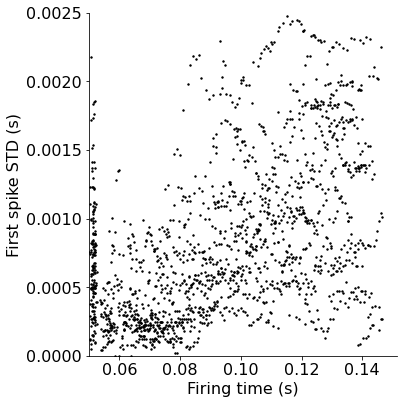

In [273]:
make_timing_precision_graphs([
     ['DROP_SEV_0.5', 'CONDITION_no_repl_no_syn_PER_SILENT_0.5_2022'],
],  np.arange(90, 93), n_exc=200)

secreted__SEED_2007_W_E_E_0.0012_W_E_I_7e-05_W_I_E_6e-05_DROP_SEV_0.5_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.5_2022-06-21--17:39--02:6435
secreted__SEED_2002_W_E_E_0.0012_W_E_I_7e-05_W_I_E_6e-05_DROP_SEV_0.5_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.5_2022-06-21--17:39--02:6544
secreted__SEED_2008_W_E_E_0.0012_W_E_I_7e-05_W_I_E_6e-05_DROP_SEV_0.5_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.5_2022-06-21--17:39--02:2681
secreted__SEED_2019_W_E_E_0.0012_W_E_I_7e-05_W_I_E_6e-05_DROP_SEV_0.5_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.5_2022-06-21--17:39--01:9033
secreted__SEED_2001_W_E_E_0.0012_W_E_I_7e-05_W_I_E_6e-05_DROP_SEV_0.5_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.5_2022-06-21--17:39--02:1671
secreted__SEED_2013_W_E_E_0.0012_W_E_I_7e-05_W_I_E_6e-05_DROP_SEV_0.5_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.5_2022-06-21--17:39--02:675

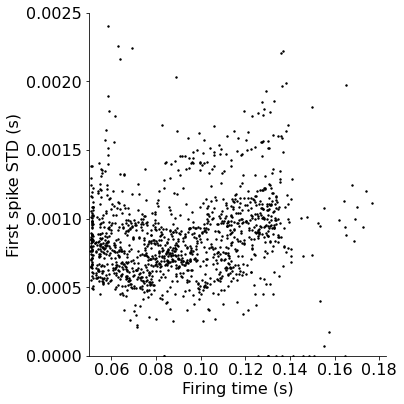

In [274]:
make_timing_precision_graphs([
     ['DROP_SEV_0.5', 'CONDITION_no_repl_no_syn_PER_SILENT_0.5_2022'],
],  np.arange(249, 259), n_exc=200)

secreted_low_growth__SEED_2000_W_E_E_0.0012_W_E_I_7e-05_W_I_E_6e-05_DROP_SEV_0.5_COMP_MECH_secreted_regulation_CONDITION_all_PER_SILENT_0_2022-06-21--23:32--32:5704
secreted_low_growth__SEED_2014_W_E_E_0.0012_W_E_I_7e-05_W_I_E_6e-05_DROP_SEV_0.5_COMP_MECH_secreted_regulation_CONDITION_all_PER_SILENT_0_2022-06-21--23:32--58:1855
secreted_low_growth__SEED_2009_W_E_E_0.0012_W_E_I_7e-05_W_I_E_6e-05_DROP_SEV_0.5_COMP_MECH_secreted_regulation_CONDITION_all_PER_SILENT_0_2022-06-21--23:32--32:0602
secreted_low_growth__SEED_2017_W_E_E_0.0012_W_E_I_7e-05_W_I_E_6e-05_DROP_SEV_0.5_COMP_MECH_secreted_regulation_CONDITION_all_PER_SILENT_0_2022-06-21--23:32--57:0209
secreted_low_growth__SEED_2002_W_E_E_0.0012_W_E_I_7e-05_W_I_E_6e-05_DROP_SEV_0.5_COMP_MECH_secreted_regulation_CONDITION_all_PER_SILENT_0_2022-06-21--23:32--33:6544
secreted_low_growth__SEED_2015_W_E_E_0.0012_W_E_I_7e-05_W_I_E_6e-05_DROP_SEV_0.5_COMP_MECH_secreted_regulation_CONDITION_all_PER_SILENT_0_2022-06-21--23:32--57:7375
secreted_l

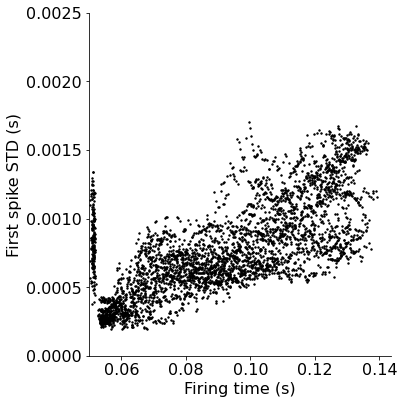

In [275]:
make_timing_precision_graphs([
     ['DROP_SEV_0.5', 'CONDITION_all_PER_SILENT_0_2022'],
],  np.arange(90, 99), n_exc=300)

secreted_low_growth__SEED_2000_W_E_E_0.0012_W_E_I_7e-05_W_I_E_6e-05_DROP_SEV_0.5_COMP_MECH_secreted_regulation_CONDITION_all_PER_SILENT_0_2022-06-21--23:32--32:5704
secreted_low_growth__SEED_2014_W_E_E_0.0012_W_E_I_7e-05_W_I_E_6e-05_DROP_SEV_0.5_COMP_MECH_secreted_regulation_CONDITION_all_PER_SILENT_0_2022-06-21--23:32--58:1855
secreted_low_growth__SEED_2009_W_E_E_0.0012_W_E_I_7e-05_W_I_E_6e-05_DROP_SEV_0.5_COMP_MECH_secreted_regulation_CONDITION_all_PER_SILENT_0_2022-06-21--23:32--32:0602
secreted_low_growth__SEED_2017_W_E_E_0.0012_W_E_I_7e-05_W_I_E_6e-05_DROP_SEV_0.5_COMP_MECH_secreted_regulation_CONDITION_all_PER_SILENT_0_2022-06-21--23:32--57:0209
secreted_low_growth__SEED_2002_W_E_E_0.0012_W_E_I_7e-05_W_I_E_6e-05_DROP_SEV_0.5_COMP_MECH_secreted_regulation_CONDITION_all_PER_SILENT_0_2022-06-21--23:32--33:6544
secreted_low_growth__SEED_2015_W_E_E_0.0012_W_E_I_7e-05_W_I_E_6e-05_DROP_SEV_0.5_COMP_MECH_secreted_regulation_CONDITION_all_PER_SILENT_0_2022-06-21--23:32--57:7375
secreted_l

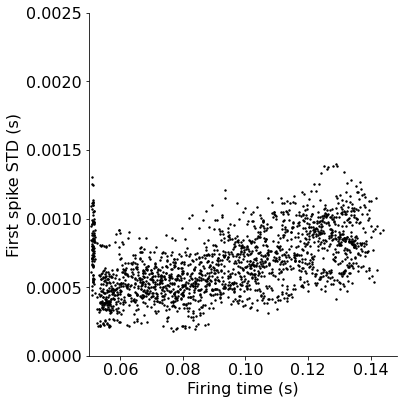

In [276]:
make_timing_precision_graphs([
     ['DROP_SEV_0.5', 'CONDITION_all_PER_SILENT_0_2022'],
],  np.arange(249, 259), n_exc=300)

In [ ]:
def make_timing_error_graphs(names, timepoints_1, timepoints_2, n_exc=300, new_cell_idx=200):
    all_dirs = []
    for name in names:
        if type(names) is list:
            all_dirs.append([dirs for dirs in filter_list_by_name_frags(all_in_dir('./robustness'), name)])
        else:
            all_dirs.append([dirs for dirs in filter_list_by_name_frags(all_in_dir('./robustness'), [name])])
    
    for i, exp_dir_names in enumerate(all_dirs):   
        scale = 1.1
        fig = plt.figure(constrained_layout=True, figsize=(5 * scale, 5 * scale))
        gs = gridspec.GridSpec(ncols=1, nrows=2, figure=fig)
        axs = [fig.add_subplot(gs[:, 0])]
        
        for j, exp_dir_name in enumerate(exp_dir_names):
            if exp_dir_name not in recovered_exp_names:
                continue
            print(exp_dir_name)
            
            j = 0
            all_first_spk_times = []

            for i, load_data in load_exp_data(os.path.join('./robustness', exp_dir_name), n_exc=n_exc):
                if j < len(timepoints) and i == timepoints[j]:
                    data = load_data()
                    first_spk_times = data['first_spk_times']
                    original_surviving_mask = np.arange(n_exc) < new_cell_idx     
                    if 'surviving_cell_mask' in data:
                        original_surviving_mask = np.logical_and(original_surviving_mask, data['surviving_cell_mask']).astype(bool)
                    first_spk_times = data['first_spk_times'][original_surviving_mask]
                    all_first_spk_times.append(first_spk_times)
                    j += 1
            
            all_first_spk_times = np.stack(all_first_spk_times)
            all_nan_means = np.nanmean(all_first_spk_times, axis=0)
            all_nan_stds = np.nanstd(all_first_spk_times, axis=0)

            axs[0].scatter(all_nan_means, all_nan_stds, s=2, c='black', zorder=0, alpha=1)

        set_font_size(axs[0], 16)
        axs[0].spines['right'].set_visible(False)
        axs[0].spines['top'].set_visible(False)

        axs[0].set_xlabel('Firing time (s)')
        axs[0].set_ylabel('First spike STD (s)')

        axs[0].set_ylim(0, 0.0025)
        axs[0].set_xlim(0.05)

In [ ]:
def make_timing_precision_graphs(names, timepoints=[600], n_exc=900):
    all_dirs = []
    for name in names:
        if type(names) is list:
            all_dirs.append([dirs for dirs in filter_list_by_name_frags(all_in_dir('./robustness'), name)])
        else:
            all_dirs.append([dirs for dirs in filter_list_by_name_frags(all_in_dir('./robustness'), [name])])
    
    for i, exp_dir_names in enumerate(all_dirs):   
        for j, exp_dir_name in enumerate(exp_dir_names):
            print(exp_dir_name)
            scale = 1.1

            fig = plt.figure(constrained_layout=True, figsize=(5 * scale, 5 * scale))
            gs = gridspec.GridSpec(ncols=1, nrows=2, figure=fig)
            axs = [fig.add_subplot(gs[:, 0])]

            j = 0

            all_first_spk_times = []

            for i, load_data in load_exp_data(os.path.join('./robustness', exp_dir_name), n_exc=n_exc):
                if j < len(timepoints) and i == timepoints[j]:
                    data = load_data()
                    first_spk_times = data['first_spk_times']
                    original_surviving_mask = np.arange(n_exc) < n_exc       
                    if 'surviving_cell_mask' in data:
                        original_surviving_mask = np.logical_and(original_surviving_mask, data['surviving_cell_mask']).astype(bool)
                        
                    first_spk_times = data['first_spk_times'][original_surviving_mask]
                    all_first_spk_times.append(first_spk_times)
                    j += 1
            
            all_first_spk_times = np.stack(all_first_spk_times)
            all_nan_means = np.nanmean(all_first_spk_times, axis=0)
            all_nan_stds = np.nanstd(all_first_spk_times, axis=0)

            axs[0].scatter(all_nan_means, all_nan_stds, s=3., c='black', zorder=0, alpha=1)

            set_font_size(axs[0], 16)
            axs[0].spines['right'].set_visible(False)
            axs[0].spines['top'].set_visible(False)
            
            axs[0].set_xlabel('Firing time (s)')
            axs[0].set_ylabel('First spike STD (s)')
            
            axs[0].set_ylim(0, 0.005)

In [167]:
def make_figure_3b(name, ylim=(0, 8), initial_timepoint_range=(90, 99), final_timepoint_range=(249, 259), n_exc=200, color='blue'):    
    all_dirs = [dirs for dirs in filter_list_by_name_frags(all_in_dir('./robustness'), name)]
            
    labels = [
        'unperturbed',
        '1500th rendition',
    ]
    
    scale = 1.9
    fig = plt.figure(constrained_layout=True, figsize=(5 * scale, 5 * scale))
    gs = gridspec.GridSpec(ncols=4, nrows=2, figure=fig)
    
    def create_split_freq_plot(row_start, row_end, col_start, fig, gs):
        sub_axs = [
            fig.add_subplot(gs[row_start:row_end, col_start]),
            fig.add_subplot(gs[row_start:row_end, (col_start+1):(col_start+3)])
        ]
        sub_axs[1].yaxis.tick_right()
        sub_axs[0].tick_params(bottom=False, labelbottom=False)
        sub_axs[0].set_xlim(-1.5, 1.5)
        sub_axs[1].set_xlim(0.5, 45)
        sub_axs[0].set_ylim(0, 1000)
        sub_axs[1].set_ylim(0, 1000)
        sub_axs[0].set_xlabel('Silent')
        sub_axs[0].spines['right'].set_visible(False)
        sub_axs[0].spines['top'].set_visible(False)
        sub_axs[1].spines['left'].set_visible(False)
        sub_axs[1].spines['top'].set_visible(False)
        return sub_axs
    
    axs = [
        create_split_freq_plot(0, 1, 0, fig, gs),
        create_split_freq_plot(1, 2, 0, fig, gs),
    ]
    
    
    firing_rate_stats_initial = {
        'spk_bins_e': None,
        'freqs_e': [],
        'spk_bins_i': None,
        'freqs_i': [],
    }
    firing_rate_stats_final = copy(firing_rate_stats_initial)
           
    for idx, exp_dir_name in enumerate(all_dirs):
        for i, data_load in load_exp_data(os.path.join('./robustness', exp_dir_name), n_exc=n_exc):
            if (i >= initial_timepoint_range[0] and i <= initial_timepoint_range[1]) or (i >= final_timepoint_range[0] and i <= final_timepoint_range[1]):
                    data = data_load()

                    spk_bins_e = data['spk_bins']
                    freqs_e = data['freqs']
                    spks_for_i_cells = data['inh_raster']
                    
                    if len(spks_for_i_cells) > 0:
                        spks_for_i_cells = spks_for_i_cells[1]
                        cell_labels, spks_i = bin_occurrences(spks_for_i_cells, min_val=n_exc, max_val=n_exc + 30, bin_size=1)
                        spk_bins_i, freqs_i = bin_occurrences(spks_i, max_val=100, bin_size=1)
                    else:
                        spk_bins_i, freqs_i = (np.zeros(100), np.zeros(100))
                        
                    if (i >= initial_timepoint_range[0] and i <= initial_timepoint_range[1]):
                        firing_rate_stats = firing_rate_stats_initial
                    else:
                        firing_rate_stats = firing_rate_stats_final
                        
                    if firing_rate_stats['spk_bins_e'] is None:
                        firing_rate_stats['spk_bins_e'] = spk_bins_e
                    if firing_rate_stats['spk_bins_i'] is None:
                        firing_rate_stats['spk_bins_i'] = spk_bins_i
                    firing_rate_stats['freqs_e'].append(freqs_e)
                    firing_rate_stats['freqs_i'].append(freqs_i)
        
    for firing_rate_stats in [firing_rate_stats_initial, firing_rate_stats_final]:
        firing_rate_stats['freqs_e_zero'] = (np.mean(np.stack(firing_rate_stats['freqs_e']), axis=0)[0], np.std(np.stack(firing_rate_stats['freqs_e']), axis=0)[0])
        firing_rate_stats['freqs_i_zero'] = (np.mean(np.stack(firing_rate_stats['freqs_i']), axis=0)[0], np.std(np.stack(firing_rate_stats['freqs_i']), axis=0)[0])
        firing_rate_stats['freqs_e'] = (np.mean(np.stack(firing_rate_stats['freqs_e']), axis=0)[1:], np.std(np.stack(firing_rate_stats['freqs_e']), axis=0)[1:])
        firing_rate_stats['freqs_i'] = (np.mean(np.stack(firing_rate_stats['freqs_i']), axis=0)[1:], np.std(np.stack(firing_rate_stats['freqs_i']), axis=0)[1:])

    freqs_e_initial_low = firing_rate_stats_initial['freqs_e'][0] - firing_rate_stats_initial['freqs_e'][1]
    freqs_e_initial_high = firing_rate_stats_initial['freqs_e'][0] + firing_rate_stats_initial['freqs_e'][1]
#     axs[0][1].fill_between(firing_rate_stats_initial['spk_bins_e'][1:], y1=freqs_e_initial_low, y2=freqs_e_initial_high, color='black', alpha=0.4, zorder=-1)
#     axs[0][1].plot(firing_rate_stats_initial['spk_bins_e'][1:], firing_rate_stats_initial['freqs_e'][0], color='black', alpha=1., zorder=-1, lw=1.2, label=labels[0])
    axs[0][1].errorbar(firing_rate_stats_initial['spk_bins_e'][1:], firing_rate_stats_initial['freqs_e'][0], yerr=firing_rate_stats_initial['freqs_e'][1], color='black', alpha=1., zorder=-1)
    axs[0][1].scatter(firing_rate_stats_initial['spk_bins_e'][1:], firing_rate_stats_initial['freqs_e'][0], color='black', alpha=1., zorder=-1, s=20, label=labels[0]) 
    
    freqs_i_initial_low = firing_rate_stats_initial['freqs_i'][0] - firing_rate_stats_initial['freqs_i'][1]
    freqs_i_initial_high = firing_rate_stats_initial['freqs_i'][0] + firing_rate_stats_initial['freqs_i'][1]
    axs[1][1].fill_between(firing_rate_stats_initial['spk_bins_i'][1:], y1=freqs_i_initial_low, y2=freqs_i_initial_high, color='blue', alpha=0.2, zorder=-1)
    axs[1][1].plot(firing_rate_stats_initial['spk_bins_i'][1:], firing_rate_stats_initial['freqs_i'][0], color='blue', alpha=0.6, zorder=-1, lw=1.2, label=labels[0] + ' inh')

    freqs_e_final_low = firing_rate_stats_final['freqs_e'][0] - firing_rate_stats_final['freqs_e'][1]
    freqs_e_final_high = firing_rate_stats_final['freqs_e'][0] + firing_rate_stats_final['freqs_e'][1]
#     axs[0][1].fill_between(firing_rate_stats_final['spk_bins_e'][1:], y1=freqs_e_final_low, y2=freqs_e_final_high, color=unperturbed_purple, alpha=0.4, zorder=-1)
#     axs[0][1].plot(firing_rate_stats_final['spk_bins_e'][1:], firing_rate_stats_final['freqs_e'][0], color=unperturbed_purple, alpha=1., zorder=0, lw=1.2, label=labels[1])
    axs[0][1].errorbar(firing_rate_stats_final['spk_bins_e'][1:], firing_rate_stats_final['freqs_e'][0], yerr=firing_rate_stats_final['freqs_e'][1], color='purple', alpha=1., zorder=-1)
    axs[0][1].scatter(firing_rate_stats_final['spk_bins_e'][1:], firing_rate_stats_final['freqs_e'][0], color='purple', alpha=1., zorder=-1, s=20, label=labels[0]) 
    
    freqs_i_final_low = firing_rate_stats_final['freqs_i'][0] - firing_rate_stats_final['freqs_i'][1]
    freqs_i_final_high = firing_rate_stats_final['freqs_i'][0] + firing_rate_stats_final['freqs_i'][1]
    axs[1][1].fill_between(firing_rate_stats_final['spk_bins_i'][1:], y1=freqs_i_final_low, y2=freqs_i_final_high, color='blue', alpha=0.4, zorder=-1)
    axs[1][1].plot(firing_rate_stats_final['spk_bins_i'][1:], firing_rate_stats_final['freqs_i'][0], color='blue', alpha=1., zorder=0, lw=1.2, label=labels[1] + ' inh')

    axs[0][0].errorbar(-.5, firing_rate_stats_initial['freqs_e_zero'][0], yerr=firing_rate_stats_initial['freqs_e_zero'][1], color='black', alpha=1., zorder=-1)
    axs[0][0].bar(-.5, firing_rate_stats_initial['freqs_e_zero'][0], color='black', alpha=0.7, zorder=-1, width=0.75)
    axs[0][0].errorbar(.5, firing_rate_stats_final['freqs_e_zero'][0], yerr=firing_rate_stats_final['freqs_e_zero'][1], color='purple', alpha=1., zorder=-1)
    axs[0][0].bar(.5, firing_rate_stats_final['freqs_e_zero'][0], color='purple', alpha=0.7, zorder=-1, width=0.75)    

    axs[1][0].errorbar(-.5, firing_rate_stats_initial['freqs_i_zero'][0], yerr=firing_rate_stats_initial['freqs_i_zero'][1], color='blue', alpha=1., zorder=-1)
    axs[1][0].bar(-.5, firing_rate_stats_initial['freqs_i_zero'][0], color='blue', alpha=0.4, zorder=-1, width=0.75)
    axs[1][0].errorbar(.5, firing_rate_stats_final['freqs_i_zero'][0], yerr=firing_rate_stats_final['freqs_i_zero'][1], color='blue', alpha=1., zorder=-1)
    axs[1][0].bar(.5, firing_rate_stats_final['freqs_i_zero'][0], color='blue', alpha=0.7, zorder=-1, width=0.75)
    
    axs[0][0].set_ylabel('Excitatory counts')
    axs[1][0].set_ylabel('Inhibitory counts')
    axs[0][1].set_xlim(0.8, 8)
#     axs[1][1].set_xlim(0.8, 60)
#     axs[0].spines['top'].set_visible(False)
#     axs[1].spines['top'].set_visible(False)
    axs[0][1].set_ylim(0, 200)
    axs[1][1].set_ylim(0, 4)
#     axs[1].set_ylim(0, 16)

#     axs[0].legend(frameon=False)
    
    for i in range(2):
        set_font_size(axs[0][i], 15)
        set_font_size(axs[1][i], 15)

    plt.locator_params(axis='x', nbins=5)
    
    save_fig(fig, './figures/paper/firing_rates', f'{" ".join(name)}.svg')

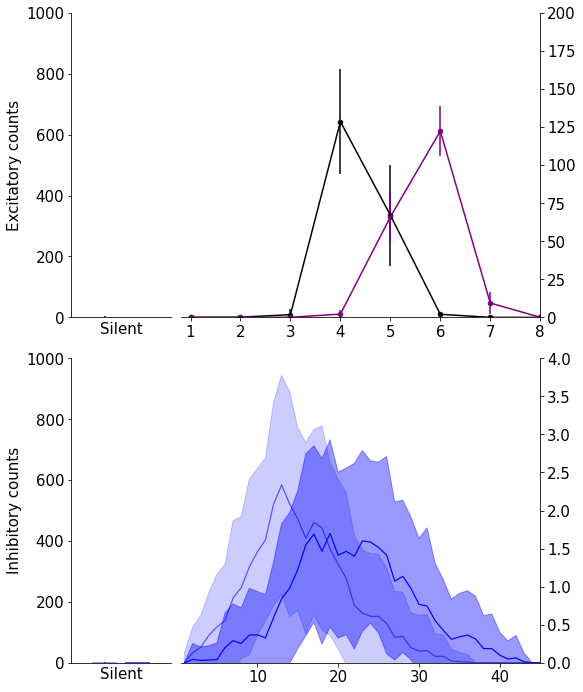

In [168]:
make_figure_3b(
    ['low_growth', 'DROP_SEV_0.5', 'CONDITION_no_repl_PER_SILENT_0_2022'],
    initial_timepoint_range=(90, 99), final_timepoint_range=(249, 259))

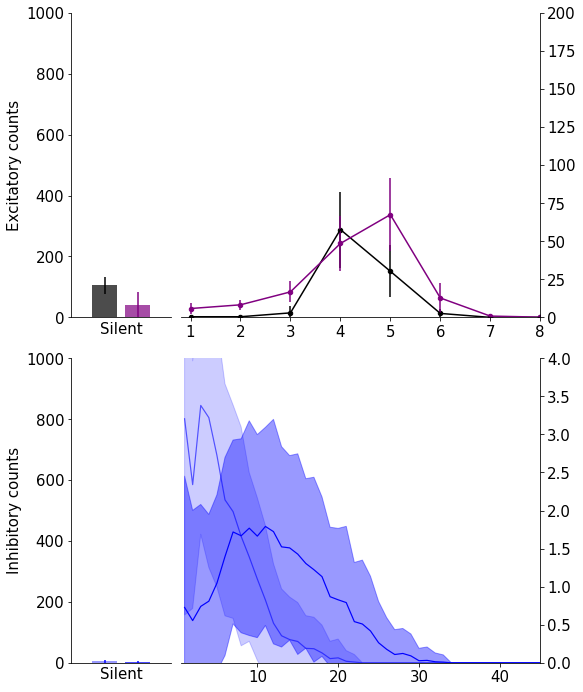

In [170]:
make_figure_3b(
    ['DROP_SEV_0.5', 'CONDITION_no_repl_no_syn_PER_SILENT_0.5_2022'],
    initial_timepoint_range=(90, 99), final_timepoint_range=(249, 259))

In [218]:
def make_figure_3c(name, ylim=(0, 8), initial_timepoint_range=(90, 99), final_timepoint_range=(249, 259), n_exc=200, color='blue', xlim1=(0, 10), xlim2=(0, 10), ylim1=(0, 10), ylim2=(0, 10)):    
    all_dirs = [dirs for dirs in filter_list_by_name_frags(all_in_dir('./robustness'), name)]
            
    labels = [
        'unperturbed',
        '1500th rendition',
    ]
    
    scale = 1.9
    fig = plt.figure(constrained_layout=True, figsize=(5 * scale, 5 * scale))
    gs = gridspec.GridSpec(ncols=4, nrows=2, figure=fig)
    
    def create_split_freq_plot(row_start, row_end, col_start, fig, gs):
        sub_axs = [
            fig.add_subplot(gs[row_start:row_end, col_start:(col_start+3)])
        ]
#         sub_axs[0].yaxis.tick_right()
        sub_axs[0].set_xlim(0, 45)
        sub_axs[0].set_ylim(0, 1000)
#         sub_axs[0].spines['left'].set_visible(False)
        sub_axs[0].spines['top'].set_visible(False)
        return sub_axs
    
    axs = [
        create_split_freq_plot(0, 1, 0, fig, gs),
        create_split_freq_plot(1, 2, 0, fig, gs),
    ]
    
    
    firing_rate_stats_initial = {
        'spk_bins_e': None,
        'freqs_e': [],
        'spk_bins_i': None,
        'freqs_i': [],
    }
    firing_rate_stats_final = copy(firing_rate_stats_initial)
           
    for idx, exp_dir_name in enumerate(all_dirs):
        for i, data_load in load_exp_data(os.path.join('./robustness', exp_dir_name), n_exc=n_exc):
            if (i >= initial_timepoint_range[0] and i <= initial_timepoint_range[1]) or (i >= final_timepoint_range[0] and i <= final_timepoint_range[1]):
                    data = data_load()

                    spk_bins_e = data['spk_bins']
                    freqs_e = data['freqs']
                    spks_for_i_cells = data['inh_raster']
                    
                    if len(spks_for_i_cells) > 0:
                        spks_for_i_cells = spks_for_i_cells[1]
                        cell_labels, spks_i = bin_occurrences(spks_for_i_cells, min_val=n_exc, max_val=n_exc + 30, bin_size=1)
                        spk_bins_i, freqs_i = bin_occurrences(spks_i, max_val=100, bin_size=1)
                    else:
                        spk_bins_i, freqs_i = (np.zeros(100), np.zeros(100))
                        
                    if (i >= initial_timepoint_range[0] and i <= initial_timepoint_range[1]):
                        firing_rate_stats = firing_rate_stats_initial
                    else:
                        firing_rate_stats = firing_rate_stats_final
                        
                    if firing_rate_stats['spk_bins_e'] is None:
                        firing_rate_stats['spk_bins_e'] = spk_bins_e
                    if firing_rate_stats['spk_bins_i'] is None:
                        firing_rate_stats['spk_bins_i'] = spk_bins_i
                    firing_rate_stats['freqs_e'].append(freqs_e)
                    firing_rate_stats['freqs_i'].append(freqs_i)
        
    for firing_rate_stats in [firing_rate_stats_initial, firing_rate_stats_final]:
        firing_rate_stats['freqs_e_zero'] = (np.mean(np.stack(firing_rate_stats['freqs_e']), axis=0)[0], np.std(np.stack(firing_rate_stats['freqs_e']), axis=0)[0])
        firing_rate_stats['freqs_i_zero'] = (np.mean(np.stack(firing_rate_stats['freqs_i']), axis=0)[0], np.std(np.stack(firing_rate_stats['freqs_i']), axis=0)[0])
        firing_rate_stats['freqs_e'] = (np.mean(np.stack(firing_rate_stats['freqs_e']), axis=0), np.std(np.stack(firing_rate_stats['freqs_e']), axis=0))
        firing_rate_stats['freqs_i'] = (np.mean(np.stack(firing_rate_stats['freqs_i']), axis=0), np.std(np.stack(firing_rate_stats['freqs_i']), axis=0))

    freqs_e_initial_low = firing_rate_stats_initial['freqs_e'][0] - firing_rate_stats_initial['freqs_e'][1]
    freqs_e_initial_high = firing_rate_stats_initial['freqs_e'][0] + firing_rate_stats_initial['freqs_e'][1]
    axs[0][0].fill_between(firing_rate_stats_initial['spk_bins_e'], y1=freqs_e_initial_low, y2=freqs_e_initial_high, color='black', alpha=0.15, zorder=-1)
    axs[0][0].plot(firing_rate_stats_initial['spk_bins_e'], firing_rate_stats_initial['freqs_e'][0], color='black', alpha=1., zorder=-1, lw=1.2, label=labels[0])
#     axs[0][0].errorbar(firing_rate_stats_initial['spk_bins_e'], firing_rate_stats_initial['freqs_e'][0], yerr=firing_rate_stats_initial['freqs_e'][1], color='black', alpha=1., zorder=-1)
#     axs[0][0].scatter(firing_rate_stats_initial['spk_bins_e'], firing_rate_stats_initial['freqs_e'][0], color='black', alpha=1., zorder=-1, s=20, label=labels[0]) 
    
    freqs_i_initial_low = firing_rate_stats_initial['freqs_i'][0] - firing_rate_stats_initial['freqs_i'][1]
    freqs_i_initial_high = firing_rate_stats_initial['freqs_i'][0] + firing_rate_stats_initial['freqs_i'][1]
    axs[1][0].fill_between(firing_rate_stats_initial['spk_bins_i'], y1=freqs_i_initial_low, y2=freqs_i_initial_high, color='blue', alpha=0.15, zorder=-1)
    axs[1][0].plot(firing_rate_stats_initial['spk_bins_i'], firing_rate_stats_initial['freqs_i'][0], '--', color='blue', alpha=0.6, zorder=-1, lw=1.2, label=labels[0] + ' inh')

    freqs_e_final_low = firing_rate_stats_final['freqs_e'][0] - firing_rate_stats_final['freqs_e'][1]
    freqs_e_final_high = firing_rate_stats_final['freqs_e'][0] + firing_rate_stats_final['freqs_e'][1]
    axs[0][0].fill_between(firing_rate_stats_final['spk_bins_e'], y1=freqs_e_final_low, y2=freqs_e_final_high, color='purple', alpha=0.15, zorder=-1)
    axs[0][0].plot(firing_rate_stats_final['spk_bins_e'], firing_rate_stats_final['freqs_e'][0], color='purple', alpha=1., zorder=0, lw=1.2, label=labels[1])
#     axs[0][0].errorbar(firing_rate_stats_final['spk_bins_e'], firing_rate_stats_final['freqs_e'][0], yerr=firing_rate_stats_final['freqs_e'][1], color='purple', alpha=1., zorder=-1)
#     axs[0][0].scatter(firing_rate_stats_final['spk_bins_e'], firing_rate_stats_final['freqs_e'][0], color='purple', alpha=1., zorder=-1, s=20, label=labels[0]) 
    
    freqs_i_final_low = firing_rate_stats_final['freqs_i'][0] - firing_rate_stats_final['freqs_i'][1]
    freqs_i_final_high = firing_rate_stats_final['freqs_i'][0] + firing_rate_stats_final['freqs_i'][1]
    axs[1][0].fill_between(firing_rate_stats_final['spk_bins_i'], y1=freqs_i_final_low, y2=freqs_i_final_high, color='blue', alpha=0.15, zorder=-1)
    axs[1][0].plot(firing_rate_stats_final['spk_bins_i'], firing_rate_stats_final['freqs_i'][0], color='blue', alpha=1., zorder=0, lw=1.2, label=labels[1] + ' inh')

#     axs[0][0].errorbar(-.5, firing_rate_stats_initial['freqs_e_zero'][0], yerr=firing_rate_stats_initial['freqs_e_zero'][1], color='black', alpha=1., zorder=-1)
#     axs[0][0].bar(-.5, firing_rate_stats_initial['freqs_e_zero'][0], color='black', alpha=0.7, zorder=-1, width=0.75)
#     axs[0][0].errorbar(.5, firing_rate_stats_final['freqs_e_zero'][0], yerr=firing_rate_stats_final['freqs_e_zero'][1], color='purple', alpha=1., zorder=-1)
#     axs[0][0].bar(.5, firing_rate_stats_final['freqs_e_zero'][0], color='purple', alpha=0.7, zorder=-1, width=0.75)    

#     axs[1][0].errorbar(-.5, firing_rate_stats_initial['freqs_i_zero'][0], yerr=firing_rate_stats_initial['freqs_i_zero'][1], color='blue', alpha=1., zorder=-1)
#     axs[1][0].bar(-.5, firing_rate_stats_initial['freqs_i_zero'][0], color='blue', alpha=0.4, zorder=-1, width=0.75)
#     axs[1][0].errorbar(.5, firing_rate_stats_final['freqs_i_zero'][0], yerr=firing_rate_stats_final['freqs_i_zero'][1], color='blue', alpha=1., zorder=-1)
#     axs[1][0].bar(.5, firing_rate_stats_final['freqs_i_zero'][0], color='blue', alpha=0.7, zorder=-1, width=0.75)
    
    axs[0][0].set_ylabel('Excitatory counts')
    axs[1][0].set_ylabel('Inhibitory counts')
    axs[0][0].set_xlabel('Spikes per rendition')
    axs[1][0].set_xlabel('Spikes per rendition')
    axs[0][0].set_xlim(xlim1)
    axs[1][0].set_xlim(xlim2)
#     axs[0].spines['top'].set_visible(False)
#     axs[1].spines['top'].set_visible(False)
    axs[0][0].set_ylim(ylim1)
    axs[1][0].set_ylim(ylim2)
#     axs[1].set_ylim(0, 16)

#     axs[0].legend(frameon=False)
    
    for i in range(1):
        set_font_size(axs[0][i], 15)
        set_font_size(axs[1][i], 15)

    plt.locator_params(axis='x', nbins=5)
    
    save_fig(fig, './figures/paper/firing_rates', f'{" ".join(name)}.svg')

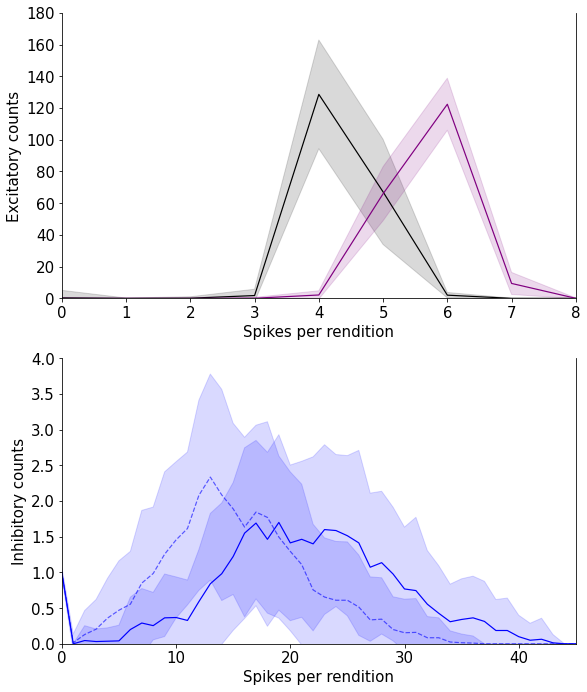

In [219]:
make_figure_3c(
    ['low_growth', 'DROP_SEV_0.5', 'CONDITION_no_repl_PER_SILENT_0_2022'],
    initial_timepoint_range=(90, 99), final_timepoint_range=(249, 259),
    xlim1=(0, 8), ylim1=(0, 180), xlim2=(0, 45), ylim2=(0, 4))

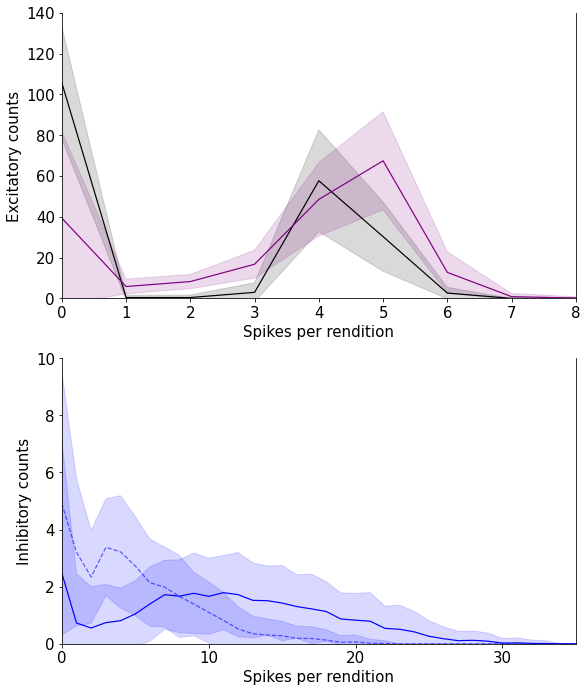

In [220]:
make_figure_3c(
    ['DROP_SEV_0.5', 'CONDITION_no_repl_no_syn_PER_SILENT_0.5_2022'],
    initial_timepoint_range=(90, 99), final_timepoint_range=(249, 259),
    xlim1=(0, 8), ylim1=(0, 140), xlim2=(0, 35), ylim2=(0, 10))

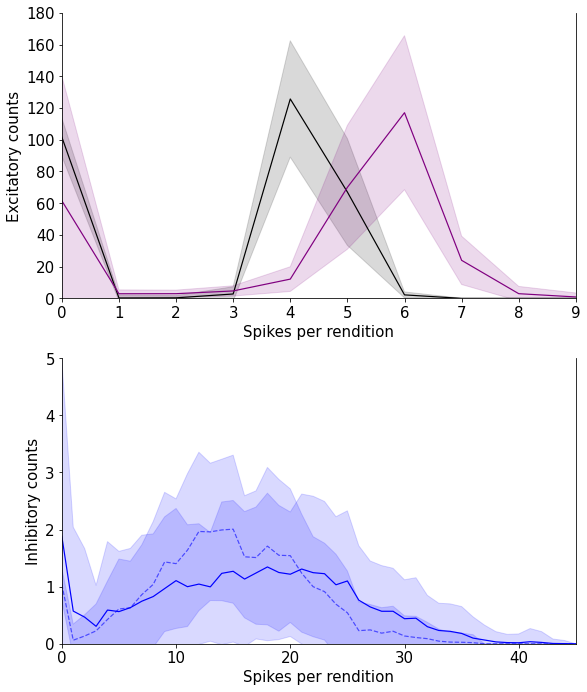

In [221]:
make_figure_3c(
    ['DROP_SEV_0.5', 'CONDITION_all_PER_SILENT_0_2022'],
    initial_timepoint_range=(90, 99), final_timepoint_range=(249, 259), n_exc=300,
    xlim1=(0, 9), ylim1=(0, 180), xlim2=(0, 45), ylim2=(0, 5))